# Alternus Vera 

Course code : **CMPE-257** 
    
Group name : **SAY**
    
Name: **Yuhua He 013803959** 

-----

GitHub URL: https://github.com/three-cobbler/AlternusVera


### Liar Liar Pants on Fire Dataset Description 
- It has 3 files test, training and valid.
- Each file has 14 columns
    
    Column 1: the ID of the statement ([ID].json).
    
    Column 2: the label.
    
    Column 3: the statement.
    
    Column 4: the subject(s).
    
    Column 5: the speaker.
    
    Column 6: the speaker's job title.
    
    Column 7: the state info.
    
    Column 8: the party affiliation.
    
    Column 9-13: the total credit history count, including the current statement.
    
    Column 14: the context (venue / location of the speech or statement).

### Process of My Approach 
- Load the Data
- Distillation Process
    - Data Cleaning and Text Preprocessing
    - Visualization
- **Feature 1 :** Corpus Structure
- Vector Classification Modeling 
- Ranking and Importance
- Merge all features and individual contributions
- Form Polynomial Equation 
    

### Feature Selection
**List top Features Selected based on research articles**



### Team Contributions example:

|Features  |  Member |
|-----|-----|
| Corpus Structure                         |  Yuhua He |  
| Feature name(s)                 |  Samuel Yang | 
| Feature name(s)                   |  Yuanzhe Li  |   

 
#### Enrichment Dataset Details

- Real news data from published articles (https://www.kaggle.com/snapcrack/all-the-news --- articles1)
- Fake news data from Kaggle (https://www.kaggle.com/mrisdal/fake-news)

#### Libraries Used 

- NLTK 
- Gensim 
- Numpy
- Pandas
- CSV
- WordCloud
- Seaborn
- Scipy
- Regualr Expression
- Matplotlib
- Sklearn 


#### What did I try and What worked? 

> For Corpus structure feature, I tried applying unigram, bigrams, 3-grams, etc from cleaned content, vectorizing the documents with TF-IDF, then apply multiple classification algorithms such as Logistic Regression, Random Forest, etc. Comparing the F1 scores for each. Vectorizing each document based on ngrams do give me the the improvements on the accuracy model provides, I also played around with the C values passed in LogisticRegression class, which also gives me slight improvements on the accuracy score.

#### What did not work?

> Even though ngrams gave the difference on the model accuracy, but with orignal liar-liar dataset, the model accuracy didn't have too much diffence, it ranges between 50% - 58%, even though I applied different classification algorithms, the model accuracy still not improved that much.


#### What alternatives did you try?

> I tried data enrichment by getting additional real news data and fake news data from kaggle, cleaned the feature content and text columns by applying and similar cleanning logic used in the original data set, enriched with the orignal dataset and feed into the same model again, and got significant improvement on the model accuracy, it goes up to 87%(logistic regression), 89%(random forest) with unigram.

----

### Reading the Data

In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuhuahe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuhuahe/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Read the test, training and valid data from files
# Header = 0 indicates that the first line of the file contains column names,
# As there is no Header, create a column names for each column in the dataset
# delimiter = \t indicates that the fields are seperated by tabs, and 


test_filename = 'input_data/dataset/test.tsv'
train_filename = 'input_data/dataset/train.tsv'
valid_filename = 'input_data/dataset/valid.tsv'

colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)

In [3]:
# Display check the dimensions and the first 2 rows of the file.

print('train dim:',train_news.shape, 'test dim:', test_news.shape)
train_news.iloc[0:2]

train dim: (10240, 14) test dim: (1267, 14)


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


## Data Cleaning and Text Preprocessing 

*Steps included in the preprocessing:*
- Remove Special Characters and Punctuations
- Lower case the news
- Tokenization
- Remove Stop Words
- Lemmatization
- Stemming 
- Spell Check 

###  Putting It All Together 

To make the code reusable, we need to create a function that can be called many times.

In [373]:
import re

def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", str(raw_news))
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [5]:
import time
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
train_news['clean'] = train_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
test_news['clean'] = test_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem test data: \n", len(test_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
valid_news['clean'] = valid_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem train data: 
 10240 news: 0.13319435119628906 min


Time to clean, tokenize and stem test data: 
 1267 news: 0.014473664760589599 min


Time to clean, tokenize and stem valid data: 
 1284 news: 0.013814302285512288 min


### [Google News corpus word2vec](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)

### Spell Check 

-  You can download the pre-trained model [**here**](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

- Or clone it from GitHub [**GoogleNews-vectors-negative300**](https://github.com/mmihaltz/word2vec-GoogleNews-vectors)

> It’s 1.5GB! It includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features.

**3 million words * 300 features * 4bytes/feature = ~3.35GB**

> This file consist of the word2vec -  pre-trained Google News corpus (3 billion running words) to word vector model (3 million 300-dimension English word vectors).

> Look at the [**vocabulory list**](https://github.com/chrisjmccormick/inspect_word2vec/tree/master/vocabulary) used to train this model. Each text file contains 100,000 entries from the model. 


>  There are few things that this dataset contains and not. It has stop words like  “the”, “also”, “should” and does not have stop words like “a”, “and”, “of”. As I have removed the stop words the complexity is reduced as there is no need to check the spelling for stop words. 

> It does have numbers but in the form of entried wiht #. e.g., you won’t find “100”. But it does include entries like “###MHz_DDR2_SDRAM”. 

The model used [**WinPython-64bit-2.7.10.3**](https://winpython.github.io/) for efficient python distribution on Windows system. Helps to run the scripts in batches. 

In [6]:
model = gensim.models.KeyedVectors.load_word2vec_format('input_data/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [7]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [8]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [9]:
print("Before: \n", train_news['clean'][0] )
t1 = time.time()
train_news['clean'] = train_news['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",train_news['clean'][0] )
train_news.head(5)

Before: 
 say anni list polit group support third trimest abort demand

Time to spell check the train data: 
 10240 news: 4.221597413221995 min

After: 
 say anni list polit group support third trimmest abort demand


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimme...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natur gas took start ...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agre john mccain vote give geo...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legis like mandat free sex ...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term


In [10]:
t1 = time.time()
test_news['clean'] = test_news['clean'].apply(spell_checker)
test_news.head(5)
t2 = time.time()
print("\nTime to spell check the test data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to spell check the test data: 
 1267 news: 0.48872586488723757 min


In [11]:
t1 = time.time()
valid_news['clean'] = valid_news['clean'].apply(spell_checker)
valid_news.head(5)
t2 = time.time()
print("\nTime to spell check the valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")


Time to spell check the valid data: 
 1284 news: 0.5521691997845968 min


##### Saved the trained dataset into a seperate CSV file 

In [12]:
train_news.to_csv("input_data/train_processed.csv", sep=',')
test_news.to_csv("input_data/test_processed.csv", sep=',')
valid_news.to_csv("input_data/valid_processed.csv", sep=',')

### Visualization 

#### WordCloud 

> As a tool for visualization by using the frequency of words appeared in text, we use WordCloud. Note that it can give more information and insight of texts by analyzing correlations and similarities between words rather than analyzing texts only by the frequency of words appeared; however, it can give you some general shape of what this text is about quickly and intuitively.

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

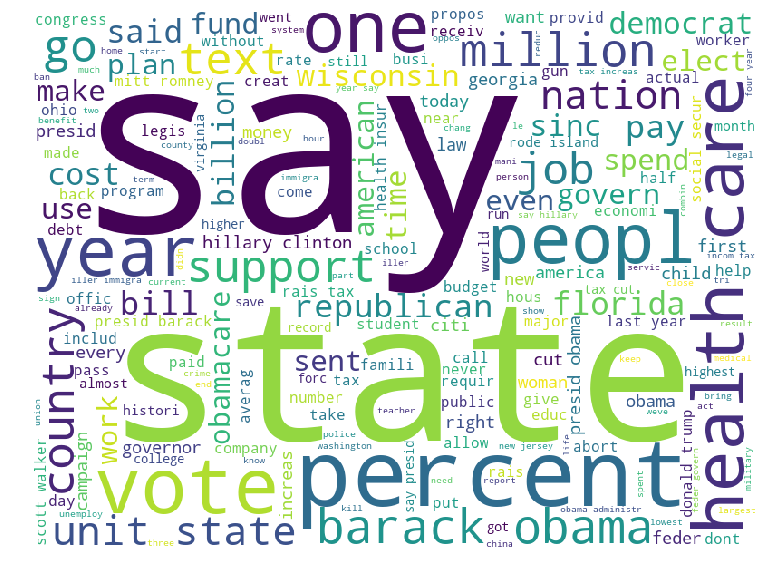

In [14]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(train_news['clean']))

#### Inferences from visulaization: 
- The large words are the words that are frequently appeared in the text/corpus


# Feature 1: Sentiment analysis 

#### Using Vader Sentiment Analyser

##### [Sentiment Intensity Analyzer](http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html)


> VADER, or the **Valence Aware Dictionary and sEntiment Reasoner** has created a package that performes sentiment analysis using the polarity-based, where pieces of texts are classified as either positive or negative, or valence-based, where the intensity of the sentiment is taken into account. For example, the words ‘good’ and ‘excellent’ would be treated the same in a polarity-based approach, whereas ‘excellent’ would be treated as more positive than ‘good’ in a valence-based approach

- It is based on lexicons of sentiment-related word.
- The first three, positive, neutral and negative, represent the proportion of the text that falls into those categories.
- The final metric, the compound score, is the sum of all of the lexicon ratings which have been standardised to range between -1 and 1

In [24]:
import warnings
import nltk.sentiment
nltk.downloader.download('vader_lexicon')
warnings.filterwarnings('ignore')

senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = senti.polarity_scores(sentence)
    print("{:-<40} \n{}".format(sentence, str(snt)))
    
print_sentiment_scores(train_news['clean'][0])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yuhuahe/nltk_data...


say anni list polit group support third trimmest abort demand 
{'neg': 0.123, 'neu': 0.656, 'pos': 0.221, 'compound': 0.296}


In [25]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

In [26]:
#Function to determine if a text is negative(-1) or postive (1) or neutral (0)
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    print(sentimentVector)
    return sentimentVector

- senti.polarity_scores is a dictionary
- pos and neg indicates - positive and negative emotions in sentence
- we should be interested in compound score which calculates the final effect

In [27]:
sentiment = []
vader_pol = []
cmp_score = []
for row in train_news['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
train_news['sentiment_vector'] = sentiment
train_news['vader_polarity'] = vader_pol
train_news['sentiment_score'] = cmp_score

[0, 0.123, 0.656, 0.221, 0.296]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.161, 0.645, 0.194, 0.128]
[1, 0.0, 0.438, 0.562, 0.8402]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.335, 0.6, 0.065, -0.7506]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.085, 0.915, 0.0, -0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.667, 0.333, 0.6124]
[0, 0.32, 0.68, 0.0, -0.5106]
[0, 0.153, 0.657, 0.19, 0.128]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.2, 0.522, 0.278, 0.2263]
[0, 0.108, 0.773, 0.119, 0.0516]
[0, 0.198, 0.802, 0.0, -0.4939]
[0, 0.0, 0.625, 0.375, 0.7184]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.68, 0.32, 0.5106]
[0, 0.0, 0.543, 0.457, 0.6369]
[0, 0.15, 0.429, 0.421, 0.5859]
[0, 0.0, 0.843, 0.157, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[-1, 0.507, 0.493, 0.0, -0.802]
[0, 0.0, 0.859, 0.141, 0.2411]
[0, 0.238, 0.495, 0.267, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.199, 0.588, 0.213, 0.0516]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.184, 0.702, 0.114, -0.2033]
[0, 0.0, 1.0, 0.0, 0.0]


In [28]:
train_news.head(5)

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.2960
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agre john mccain vote give geo...,"[0.161, 0.645, 0.194, 0.128]",0,0.1280
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legis like mandat free sex ...,"[0.0, 0.438, 0.562, 0.8402]",1,0.8402
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,"[0.0, 1.0, 0.0, 0.0]",0,0.0000


In [29]:
sentiment = []
vader_pol = []
cmp_score = []

for row in test_news['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
    
test_news['sentiment_vector'] = sentiment
test_news['vader_polarity'] = vader_pol
test_news['sentiment_score'] = cmp_score

[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.794, 0.206, 0.0772]
[0, 0.0, 0.69, 0.31, 0.4019]
[0, 0.164, 0.469, 0.367, 0.3818]
[0, 0.169, 0.688, 0.143, -0.128]
[0, 0.0, 0.812, 0.188, 0.4588]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.239, 0.645, 0.116, -0.4404]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.279, 0.721, 0.0, -0.4767]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.286, 0.714, 0.0, -0.34]
[0, 0.195, 0.805, 0.0, -0.5267]
[0, 0.351, 0.36, 0.288, -0.1779]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.657, 0.343, 0.5719]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.241, 0.759, 0.0, -0.5859]
[0, 0.0, 0.737, 0.263, 0.3612]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.642, 0.358, 0.5994]
[0, 0.0, 0.921, 0.079, 0.0516]
[0, 0.277, 0.566, 0.157, -0.4404]
[0, 0.0, 0.735, 0.265, 0.5574]
[0, 0.0, 0.769, 0.231, 0.4588]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.182, 0.579, 0.24, 0.1779]
[0, 0.296, 0.704, 0.0, -

In [30]:
test_news.head(5)

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,say john mccain done noth help vet,"[0.0, 0.69, 0.31, 0.4019]",0,0.4019
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,suzanne bonamici support plan cut choice medic...,"[0.164, 0.469, 0.367, 0.3818]",0,0.3818
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,ask report whether he center crimini scheme vi...,"[0.169, 0.688, 0.143, -0.128]",0,-0.1280


In [31]:
sentiment = []
vader_pol = []
cmp_score = []

for row in valid_news['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
    
valid_news['sentiment_vector'] = sentiment
valid_news['vader_polarity'] = vader_pol
valid_news['sentiment_score'] = cmp_score

[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.13, 0.87, 0.0, -0.34]
[0, 0.383, 0.617, 0.0, -0.4767]
[0, 0.181, 0.819, 0.0, -0.4767]
[-1, 0.622, 0.378, 0.0, -0.93]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.17, 0.609, 0.222, 0.0516]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.162, 0.838, 0.0, -0.4019]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.211, 0.789, 0.0, -0.1531]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.802, 0.198, 0.6369]
[0, 0.209, 0.791, 0.0, -0.4404]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.306, 0.694, 0.0, -0.296]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.248, 0.752, 0.0, -0.6036]
[0, 0.346, 0.654, 0.0, -0.5719]
[-1, 0.524, 0.476, 0.0, -0.5106]
[1, 0.0, 0.449, 0.551, 0.8225]
[0, 0.296, 0.704, 0.0, -0.2732]
[0, 0.213, 0.551, 0.236, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[-1, 0.528, 0.472, 0.0, -0.7717]
[0, 0.0, 0.776, 0.224, 0.3818]
[0, 0.226, 0.685, 0.089, -0.4588]
[0, 0.327, 0.442, 0.23, -0.2732]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.196, 0.804, 0.0, -0.296]
[0, 0.0, 1.0, 0.0, 0

In [32]:
valid_news.head(5)

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,le american work,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,obama sworn offic use holi bill instead kura e...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,say organ parade social welfare organ involv p...,"[0.13, 0.87, 0.0, -0.34]",0,-0.3400
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,say near half oregon child poor,"[0.383, 0.617, 0.0, -0.4767]",0,-0.4767
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,attack republican various program econom stimu...,"[0.181, 0.819, 0.0, -0.4767]",0,-0.4767


##### Saved the trained dataset into a seperate CSV file 

In [33]:
train_news.to_csv("input_data/train_sentiment.csv", sep=',')
test_news.to_csv("input_data/test_sentiment.csv", sep=',')
valid_news.to_csv("input_data/valid_sentiment.csv", sep=',')

In [34]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class SentimentAnalysis():

    def __init__(self):        

        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score"]
        dataTrain = pd.read_csv('input_data/train_sentiment.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('input_data/test_sentiment.csv', sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
    
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['vader_polarity'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['vader_polarity'], predicted_LogR)
        print("Sentiment Analysis Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
sa = SentimentAnalysis()
sa.predict("Says the Annies List political group supports third-trimester abortions on demand.")

Sentiment Analysis Model Trained - accuracy:   0.943918


(True, 0.9448046694778502)

In [35]:
SentimentAnalysis = SentimentAnalysis()

Sentiment Analysis Model Trained - accuracy:   0.943918


In [36]:
def DATAMINERS_getSentimentAnalysisScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = SentimentAnalysis.predict(text)
    return (float(probValue))

print(DATAMINERS_getSentimentAnalysisScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.9448046694778502


In [60]:
# Corpus structure



# Feature 2:  LDA Topic Modelling 


In [37]:
train_news['index'] = train_news.index
data = train_news
train_lda = data[['clean', 'index']]
train_lda.head(4)

,clean,index
0,say anni list polit group support third trimme...,0
1,decline coal start start natur gas took start ...,1
2,hillary clinton agre john mccain vote give geo...,2
3,health care reform legis like mandat free sex ...,3


In [38]:
test_news['index'] = test_news.index
data = test_news
test_lda = data[['clean', 'index']]
test_lda.head(4)

,clean,index
0,build wall u mexico border take liter year,0
1,wisconsin pace doubl number layoff year,1
2,say john mccain done noth help vet,2
3,suzanne bonamici support plan cut choice medic...,3


In [39]:
valid_news['index'] = valid_news.index
data = valid_news
valid_lda = data[['clean', 'index']]
valid_lda.head(4)

,clean,index
0,le american work,0
1,obama sworn offic use holi bill instead kura e...,1
2,say organ parade social welfare organ involv p...,2
3,say near half oregon child poor,3


#### Split the clean news into list of words

In [40]:
processed_docs = train_lda['clean'].map(lambda doc: doc.split(" "))
processed_docs[:4]

0    [say, anni, list, polit, group, support, third...
1    [decline, coal, start, start, natur, gas, took...
2    [hillary, clinton, agre, john, mccain, vote, g...
3    [health, care, reform, legis, like, mandat, fr...
Name: clean, dtype: object

### Latent Dirichlet Allocation (LDA)

> It is an example of a probabilistic topic model. Topic models are a great way to automatically explore and structure a large set of documents: they group or cluster documents based on the words that occur in them. As documents on similar topics tend to use a similar sub-vocabulary, the resulting clusters of documents can be interpreted as discussing different 'topics'.

In [41]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
tokenized_docs_local = train_news['clean'].map(get_word_tokens)

### Create a function to build the dictionary and tokenized docs for given feature

Below function does the following
* #### Dictionary
Returns Dictionary given, dataframe and column name
* #### Tokenizeddocs
Returns Tokenizeddocs, of the all the words in a text in that column can be used for bow_corpus
* #### Dictionary is filtered using Gensim filter_extremes
    Filter out tokens that appear in less than 15 documents (absolute number) or more than 0.5 documents (fraction of total corpus size, not absolute number). after the above two steps, keep only the first 100000 most frequent tokens.


In [42]:
def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

#### Gensim filter_extremes

> Filter out tokens that appear less than 15 documents (absolute number) or more than 0.5 documents (fraction of total corpus size, not absolute number). after the above two steps, keep only the first 100000 most frequent tokens.

#### Create a function to build bow_corpus from dictionary and tokenized_docs

In [43]:
def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

**Gensim doc2bow**

For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier

#### Create a function to build tfidf_corpus from bow_corpus

Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [44]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n ######## TFIDF VECTOR FIRST ITEM ########')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

#### Create a function to run ldamodel and print top 10 topics

In [45]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

#### Create a function to run ldamodel and print top 10 topics

In [46]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

#### Create a function to enrich data with lda topics, lda topics score, top words

In [47]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

#### Create a function that can enrich topic data to dataframe

In [48]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

### Bag of Words

#### Create a dictionary and tokens

> Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

#### Create a function to convert text to word tokens from cleaned dataset

In [59]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(train_news,
                                                                      'clean')

######## DICTIONARY Words and occurences ########
0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 third
9 trimmest
10 administr

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (6, 1), (7, 1)]

 ######## PREVIEW BOW ########
Word 0 ("abort") appears 1 time.
Word 1 ("demand") appears 1 time.
Word 2 ("group") appears 1 time.
Word 3 ("list") appears 1 time.
Word 4 ("polit") appears 1 time.
Word 6 ("support") appears 1 time.
Word 7 ("third") appears 1 time.


### Running LDA using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [50]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['vote', 'sent', 'republican', 'support', 'democrat', 'state', 'obama', 'romney', 'presid', 'percent']
1::['percent', 'state', 'time', 'averag', 'year', 'american', 'school', 'hous', 'billion', 'rais']
2::['presid', 'obama', 'bill', 'country', 'barack', 'state', 'year', 'bush', 'billion', 'florida']
3::['year', 'percent', 'school', 'would', 'budget', 'public', 'every', 'state', 'debt', 'spend']
4::['obama', 'state', 'nation', 'million', 'said', 'work', 'peopl', 'presid', 'clinton', 'text']
5::['percent', 'year', 'million', 'state', 'obama', 'time', 'rate', 'peopl', 'presid', 'wisconsin']
6::['percent', 'increas', 'american', 'peopl', 'state', 'year', 'sinc', 'health', 'care', 'want']
7::['year', 'last', 'state', 'million', 'vote', 'creat', 'health', 'number', 'would', 'nation']
8::['health', 'care', 'state', 'year', 'cost', 'would', 'percent', 'plan', 'insur', 'budget']
9::['state', 'trump', 'unit', 'donald', 'georgia', 'clinton', 'want', 'percent', 'feder', 'iller']


#### Generate TF-IDF bow_corpus
Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [51]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 ######## TFIDF VECTOR FIRST ITEM ########
[(0, 0.3213684467163471),
 (1, 0.45885933393208955),
 (2, 0.3867148870952622),
 (3, 0.4388676762258462),
 (4, 0.3854712129906647),
 (6, 0.25709294587835624),
 (7, 0.3596280760961804)]


### Running LDA model using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

**GOAL**: To get top ten topics with top words. 

In [52]:
lda_tfidf_model_headline  = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['state', 'budget', 'billion', 'educ', 'reagan', 'year', 'percent', 'bring', 'test', 'help']
1::['year', 'percent', 'state', 'sinc', 'world', 'rate', 'creat', 'last', 'wisconsin', 'unit']
2::['american', 'percent', 'feder', 'medicaid', 'health', 'insur', 'year', 'million', 'govern', 'state']
3::['clinton', 'said', 'percent', 'hillary', 'peopl', 'american', 'major', 'wage', 'hous', 'state']
4::['romney', 'mitt', 'state', 'rick', 'percent', 'million', 'school', 'dollar', 'year', 'obama']
5::['billion', 'year', 'cost', 'state', 'dollar', 'employe', 'crist', 'half', 'governor', 'food']
6::['care', 'health', 'vote', 'republican', 'percent', 'support', 'social', 'secur', 'democrat', 'plan']
7::['obama', 'presid', 'year', 'percent', 'iller', 'troop', 'immigra', 'island', 'state', 'increas']
8::['trump', 'court', 'donald', 'obama', 'presid', 'time', 'john', 'supreme', 'weapon', 'said']
9::['medical', 'obama', 'state', 'there', 'plan', 'barack', 'percent', 'vote', 'govern', 'ryan']


#### Explanation for LDA 
![[Explanation of LDA](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1508239587/n4ZpIXl_egq7mq.png)](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1508239587/n4ZpIXl_egq7mq.png)

### Semisupervised Labeling
Based on train,test and valid data explored the topic scores for sample data and identified below topics

In [53]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

####  Function to add topicnumber, topicscore, topiclabel, topwords

In [54]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
train_news = update_lda_results_to_dataset(
    train_news, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,...,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0.0,a mailer,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.2960,0,4,0.653330,obama state nation million said work peopl pre...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0.0,a floor speech.,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,1,5,0.930735,percent year million state obama time rate peo...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,9.0,Denver,hillary clinton agre john mccain vote give geo...,"[0.161, 0.645, 0.194, 0.128]",0,0.1280,2,6,0.539795,percent increas american peopl state year sinc...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,44.0,a news release,health care reform legis like mandat free sex ...,"[0.0, 0.438, 0.562, 0.8402]",1,0.8402,3,8,0.663693,health care state year cost would percent plan...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,2.0,an interview on CNN,econom turnaround start end term,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,4,7,0.435316,year last state million vote creat health numb...


In [55]:
test_news = update_lda_results_to_dataset(
    test_news,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)
test_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,...,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,...,18,Radio interview,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,0,4,0.871364,obama state nation million said work peopl pre...
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,...,0,a news conference,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772,1,7,0.633420,year last state million vote creat health numb...
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,...,61,comments on ABC's This Week.,say john mccain done noth help vet,"[0.0, 0.69, 0.31, 0.4019]",0,0.4019,2,8,0.581259,health care state year cost would percent plan...
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,...,1,a radio show,suzanne bonamici support plan cut choice medic...,"[0.164, 0.469, 0.367, 0.3818]",0,0.3818,3,8,0.849976,health care state year cost would percent plan...
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,...,7,a web video,ask report whether he center crimini scheme vi...,"[0.169, 0.688, 0.143, -0.128]",0,-0.1280,4,8,0.576863,health care state year cost would percent plan...


In [61]:
valid_news = update_lda_results_to_dataset(
    valid_news,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)
valid_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,...,pantsonfirecounts,context,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,...,0,an interview with ABC17 News,le american work,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,0,4,0.699907,obama state nation million said work peopl pre...
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,...,105,NaN,obama sworn offic use holi bill instead kura e...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,1,2,0.601020,presid obama bill country barack state year bu...
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,...,0,a U.S. Ways and Means hearing,say organ parade social welfare organ involv p...,"[0.13, 0.87, 0.0, -0.34]",0,-0.3400,2,4,0.602061,obama state nation million said work peopl pre...
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,...,0,an opinion article,say near half oregon child poor,"[0.383, 0.617, 0.0, -0.4767]",0,-0.4767,3,4,0.849956,obama state nation million said work peopl pre...
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,...,9,interview with CBS News,attack republican various program econom stimu...,"[0.181, 0.819, 0.0, -0.4767]",0,-0.4767,4,0,0.565717,vote sent republican support democrat state ob...


### Visualize the LDA Distribution of news against Top 10 Topics

**GOAL 1:** *Each of the N documents will be represented in the LDA model by a vector of length M*
**GOAL 2:** *Each of the M topics is represented by a vector of length V*

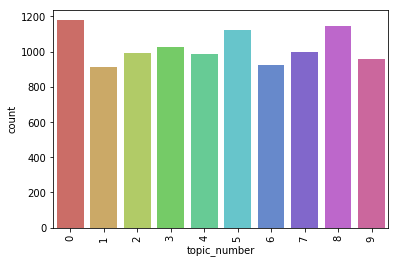

In [62]:
import seaborn as sb
def create_distribution(dataFile):
    g = sb.countplot(x='topic_number', data=dataFile, palette='hls')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

    return g

create_distribution(train_news) # TRAIN Document Vector

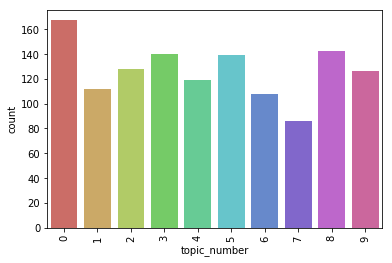

In [63]:
create_distribution(test_news)# TEST Document Vector

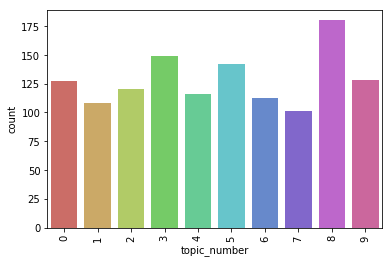

In [64]:
create_distribution(valid_news)# VALID Document Vector

##### Saved the latest dataset into a seperate CSV file 

In [65]:
train_news.to_csv("input_data/train_lda.csv", sep=',')
test_news.to_csv("input_data/test_lda.csv", sep=',')
valid_news.to_csv("input_data/valid_lda.csv", sep=',')

In [66]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class LDATopicModelling():

    def __init__(self):        

        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
        dataTrain = pd.read_csv('input_data/train_lda.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('input_data/test_lda.csv', sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
    
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['topic_number'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['topic_number'], predicted_LogR)
        print("LDA Topic Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
# lda = LDATopicModelling()
# lda.predict("Says the Annies List political group supports third-trimester abortions on demand.")

In [67]:
ldaTopicModelling = LDATopicModelling()

LDA Topic Model Trained - accuracy:   0.333333


In [68]:
def DATAMINERS_getLDATopicModellingScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = ldaTopicModelling.predict(text)
    return (float(probValue))

print(DATAMINERS_getLDATopicModellingScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.07937514419578065


# Feature 3:  Sensational Feature Analysis

#### [Sensational Words Corpus](https://www.thepersuasionrevolution.com/380-high-emotion-persuasive-words/)

>  Words aren’t just strings of alphabets sewn together with ink. Words are cues. Words are triggers. Words when used correctly can transform an “eh whatever” into “wow that’s it!”. Words can make you go from literally ROFL to fuming with fury to an uncontrollable-urge-to-take-action-NOW-or-the-earth-may-stop-swinging -on-its-axis.

> Highly emotional words are capable capable of transforming an absolute no into almost yes and a “perhaps” into “for sure”!

Words that are used:
- When you are trying to sell people a solution
- When you are trying to get them to take an action (like, share, subscribe, buy)
- When you are trying to get people to click and read your article
- When you are trying to get someone to agree with you

**There are 1400+ words that are both positive and negative emotions that will help to predict the sensational score for an article**

> I have used these words to perform cosin similarity and predict the sensational similarity score for each news in the give dataset.

In [69]:
columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
dataTrain = pd.read_csv('input_data/train_lda.csv', sep=',', header=None, names = columnNames)
dataTest = pd.read_csv('input_data/test_lda.csv', sep=',', header=None, names = columnNames)

#dropping columns
columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index', 'topic_number', 'lda_score', 'topic_top_words']
train_news = dataTrain.drop(columns=columnsToRemove)
test_news = dataTest.drop(columns=columnsToRemove)
train_news = train_news.loc[1:] 
test_news = test_news.loc[1:]
    

In [70]:
corpus = []
for i in train_news['clean']:
    corpus.append(i)
# corpus

sensational_corpus=[]
sensational_words = pd.read_csv('input_data/sensationalism/sensational_words_dict.csv', sep="\t+", header=None, usecols=[0] )
print(len(sensational_words))
sensational_dictionary = ' '.join(sensational_words[0].astype(str))
sensational_corpus.append(sensational_dictionary)

1443


## SenticNet:   

#### Data Enrichment 

> It provides polarity associated with 50,000 natural language concepts. A polarity is a floating number between -1 and +1. Minus one is extreme negativity, and plus one is extreme positivity. The knowledge base is free. It can be downloaded as XML file. 
SenticNet 5 reaches 100,000 commonsense concepts by employing recurrent neural networks to infer primitives by lexical substitution.

In [71]:
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")
sentic_net = pd.read_csv('input_data/sensationalism/senticnet5.txt', sep="\t+", header=None, usecols=[0,1,2], names = ["Token", "Polarity", "Intensity"])
sentic_net = sentic_net[~sentic_net['Token'].str.contains('|'.join('_'),na=False)]
sentic_net = sentic_net.reset_index(drop=True)
print("Senticnet Vocab Size: ",len(sentic_net))
print(sentic_net.head(10))

Senticnet Vocab Size:  39891
         Token  Polarity  Intensity
0      abandon  negative      -0.84
1    abandoned  negative      -0.85
2  abandonment  negative      -0.82
3        abase  negative      -0.90
4    abasement  negative      -0.90
5        abash  negative      -0.77
6      abashed  negative      -0.92
7    abashment  negative      -0.76
8       abasia  negative      -0.67
9        abate  negative      -0.86


In [72]:
# sentic_net['Token'] provides list of words from the SenticNet DICTIONARY
senti_pos = sentic_net.loc[sentic_net.Polarity == "positive"]
senti_pos = senti_pos.loc[senti_pos.Intensity > 0.90]
dictionary = ' '.join(senti_pos.Token.astype(str))
sensational_corpus.append(dictionary)
print(len(senti_pos))

2040


## TF-IDF and Cosine Similarity

#### TF-IDF

> TF-IDF (Term Frequency - Inverse Document Frequency) can be represented tf(d,t) X idf(t). TF-IDF uses the method diminishing the weight (importance) of words appeared in many documents in common, considered them incapable of discerning the documents, rather than simply counting the frequency of words as CountVectorizer does. The outcome matrix consists of each document (row) and each word (column) and the importance (weight) computed by tf * idf (values of the matrix)

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVec = TfidfVectorizer(max_features=1000)

tfidf_corpus = tfidfVec.fit_transform(corpus)
tf_idf_senti = tfidfVec.fit_transform(sensational_corpus)
words = tfidfVec.get_feature_names()

In [74]:
tfidf_corpus.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
tf_idf_senti.toarray()

array([[0.02934579, 0.05869158, 0.05869158, ..., 0.        , 0.        ,
        0.08803737],
       [0.        , 0.        , 0.        , ..., 0.19269152, 0.06423051,
        0.        ]])

In [76]:
tfidfVec.vocabulary_

{'absolutely': 1,
 'advantage': 3,
 'qaeda': 742,
 'amazing': 4,
 'antagonistic': 6,
 'attack': 14,
 'authentic': 15,
 'authority': 16,
 'banned': 21,
 'behind': 24,
 'the': 929,
 'scenes': 881,
 'best': 26,
 'bill': 28,
 'bitterness': 29,
 'black': 31,
 'market': 187,
 'blacklisted': 32,
 'blissful': 34,
 'up': 990,
 'breathtaking': 37,
 'campaign': 40,
 'for': 95,
 'censored': 42,
 'cheer': 44,
 'cheerful': 45,
 'church': 47,
 'class': 48,
 'concealed': 52,
 'confessions': 53,
 'confidential': 55,
 'control': 59,
 'controversial': 61,
 'cost': 62,
 'cover': 63,
 'crime': 64,
 'critical': 65,
 'infrastructure': 126,
 'cyber': 67,
 'security': 886,
 'terror': 928,
 'daring': 68,
 'of': 388,
 'desire': 71,
 'disastrous': 72,
 'drug': 76,
 'ecstatic': 79,
 'on': 409,
 'emergency': 81,
 'response': 859,
 'enforcement': 83,
 'eye': 85,
 'opening': 415,
 'faith': 86,
 'faithfulness': 87,
 'fbi': 89,
 'first': 93,
 'responder': 858,
 'high': 118,
 'forbidden': 96,
 'force': 97,
 'fire': 92,


In [77]:
train_tfidf = tfidfVec.fit_transform(train_news['clean'])
print('Training dim:', train_tfidf.shape)
print(train_tfidf.A[:10])


test_tfidf = tfidfVec.fit_transform(test_news['clean'])
print('Test dim:', test_tfidf.shape)
print(test_tfidf.A[:10])


# valid_tfidf = tfidfVec.fit_transform(valid_news['clean'])
# print('Valid dim:', valid_tfidf.shape)
# print(valid_tfidf.A[:10])

Training dim: (10239, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Test dim: (1266, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]



#### Cosine Similarity Score

> The cosine similarity between two vectors (or two documents on the Vector Space) is a measure that calculates the cosine of the angle between them. This metric is a measurement of orientation and not magnitude, it can be seen as a comparison between documents on a normalized space because we’re not taking into the consideration only the magnitude of each word count (tf-idf) of each document, but the angle between the documents.

> I have compared the sentiment vector of each doucment and estimated a similarity score which is saved as a column in the training and test dataset. 

In [78]:
# from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
similarity_score = []
for i in range(len(train_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))

In [79]:
train_news['sensational_score'] = similarity_score
train_news.head(5)

,headline_text,clean,sensational_score
1.0,When did the decline of coal start? It started...,decline coal start start natur gas took start ...,0.061786
2.0,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agre john mccain vote give geo...,0.059743
3.0,Health care reform legislation is likely to ma...,health care reform legis like mandat free sex ...,0.052559
4.0,The economic turnaround started at the end of ...,econom turnaround start end term,0.066800
5.0,The Chicago Bears have had more starting quart...,chicago bear start quarterback last year total...,0.048691


In [80]:
corpus = []
for i in test_news['clean']:
    corpus.append(i)
# corpus

tfidf_corpus = tfidfVec.fit_transform(corpus)

similarity_score = []
for i in range(len(test_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))
    
test_news['sensational_score'] = similarity_score
test_news.head(5)

,headline_text,clean,sensational_score
1.0,Wisconsin is on pace to double the number of l...,wisconsin pace doubl number layoff year,0.019047
2.0,Says John McCain has done nothing to help the ...,say john mccain done noth help vet,0.026551
3.0,Suzanne Bonamici supports a plan that will cut...,suzanne bonamici support plan cut choice medic...,0.061022
4.0,When asked by a reporter whether hes at the ce...,ask report whether he center crimini scheme vi...,0.065230
5.0,Over the past five years the federal governmen...,past five year feder govern paid million retir...,0.066946


##### Saved the latest dataset into a seperate CSV file 

In [81]:
train_news.to_csv("input_data/train_sensationalism.csv", sep=',')
test_news.to_csv("input_data/test_sensationalism.csv", sep=',')
valid_news.to_csv("input_data/valid_sensationalism.csv", sep=',')

In [82]:
import numpy as np
columnNames = ["jsonid", "headline_text", "clean", "sensational_score"]
dataTrain = pd.read_csv('input_data/train_sensationalism.csv', sep=',', header=None, names = columnNames)
dataTest = pd.read_csv('input_data/test_sensationalism.csv', sep=',', header=None, names = columnNames)

dataTrain = dataTrain.loc[1:]
dataTest = dataTest.loc[1:]


dataTrain.head(5)

,jsonid,headline_text,clean,sensational_score
1,1.0,When did the decline of coal start? It started...,decline coal start start natur gas took start ...,0.0617855637213337
2,2.0,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agre john mccain vote give geo...,0.05974269381960995
3,3.0,Health care reform legislation is likely to ma...,health care reform legis like mandat free sex ...,0.05255867153636662
4,4.0,The economic turnaround started at the end of ...,econom turnaround start end term,0.0667999552542814
5,5.0,The Chicago Bears have had more starting quart...,chicago bear start quarterback last year total...,0.04869082661404933


In [83]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Imputer


class SensationalismFeature():

    def __init__(self):        

        columnNames = ["jsonid", "headline_text", "clean", "sensational_score"]
        dataTrain = pd.read_csv('input_data/train_sensationalism.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('input_data/test_sensationalism.csv', sep=',', header=None, names = columnNames)
        dataTrain = dataTrain.loc[1:]
        dataTest = dataTest.loc[1:]
            
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df = 30, use_idf = True, smooth_idf = True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf', LogisticRegression(solver='liblinear', C = 32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'], dataTrain['sensational_score'].astype(str))
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['sensational_score'].astype(str), predicted_LogR)
        print("Sensationalism Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
sf = SensationalismFeature()
# sf.predict("Says the Annies List political group supports third-trimester abortions on demand.")

Sensationalism Model Trained - accuracy:   0.031596


In [84]:
def DATAMINERS_getSensationalismScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = sf.predict(text)
    return (float(probValue*100))

print(DATAMINERS_getSensationalismScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.010105770859692713


# Feature 4: Political Affiliation Model 

In [85]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import itertools

class PartyAffiliation():
    
    # API to check whether the subject(Headline) is present in the 
    # - democrats most used words if the party affiliation is democrat
    # - republicans most used words if the part affiliation is republican
    def partyAffiliationFromHeadline(self, r):
        v = r['subject_str']
        p = r['party_str']
        if (p =='democrat'):
            s2 = set(self.countDemV.get_feature_names())
        if (p =='republican'):
            s2 = set(self.countRepV.get_feature_names())
        if (p != 'democract' and p !='republican'):
            return 1 #'true'        
        if set(v).intersection(s2):
            return 1 #'true'
        else:
            return 0 #'false'

    #API to convert true, mostly-true and half-true to true
    # false, barely-true and pants-fire to false
    def convertMulticlassToBinaryclass(self, r):
        v = r['label']
        if (v == 'true'):
            return 1 #'true'
        if (v == 'mostly-true'):
            return 1 #'true'
        if (v == 'half-true'):
            return 1 #'true'
        if (v == 'barely-true'):
            return 0 #'false'
        if (v == 'false'):
            return 0 #'false'
        if (v == 'pants-fire'):
            return 0 #'false'
            
            
            
    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')       
            
    
    def __init__(self):        

        columnNamesPar = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
        dataTrainPar = pd.read_csv('input_data/dataset/train.tsv', sep='\t', header=None, names = columnNamesPar)
        dataValidatePar = pd.read_csv('input_data/dataset/valid.tsv', sep='\t', header=None, names = columnNamesPar)
        dataTestPar = pd.read_csv('input_data/dataset/test.tsv', sep='\t', header=None, names = columnNamesPar)
        
    
        # Remove unwanted columns in the dataset
        columnsToRemovePar = ['id', 'speaker', 'context','speaker_job_title', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
        dataTrainPar = dataTrainPar.drop(columns=columnsToRemovePar)
        dataValidatePar = dataValidatePar.drop(columns=columnsToRemovePar)
        dataTestPar = dataTestPar.drop(columns=columnsToRemovePar)
        
        # convert the labels to true and false only
        dataTrainPar['label'] = dataTrainPar.apply(self.convertMulticlassToBinaryclass, axis=1)
        dataValidatePar['label'] = dataValidatePar.apply(self.convertMulticlassToBinaryclass, axis=1)
        dataTestPar['label'] = dataTestPar.apply(self.convertMulticlassToBinaryclass, axis=1)
        
        # display all the party affiliations and show the count of each party 
#         dataTrainPar.groupby('party_affiliation').count()[['state_info']].rename(
#         columns={'state_info': 'count'}).sort_values(
#         'count', ascending=False).reset_index().plot.bar(
#         x='party_affiliation', y='count', figsize=(16, 10), fontsize=18);
        
        # As we are considering only democrat, republican and none (top 3 party affiliations),
        # ignoring other party affiliations
        rowsToRemove = ['Moderate', 'activist', 'business-leader', 'columnist', 'constitution-party', 'democratic-farmer-labor', 'education-official', 'government-body', 'green', 'independent', 'journalist', 'labor-leader', 'liberal-party-canada', 'libertarian', 'nan', 'newsmaker', 'ocean-state-tea-party-action', 'organization', 'state-official', 'talk-show-host', 'tea-party-member']

        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'Moderate']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'activist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'business-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'columnist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'constitution-party']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'democratic-farmer-labor']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'education-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'government-body']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'green']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'independent']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'journalist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'labor-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'liberal-party-canada']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'libertarian']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'nan']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'newsmaker']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'ocean-state-tea-party-action']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'organization']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'state-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'talk-show-host']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'tea-party-member']

        # As we are considering only democrat, republican and none (top 3 party affiliations),
        # ignoring other party affiliations

        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'Moderate']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'activist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'business-leader']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'columnist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'constitution-party']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'democratic-farmer-labor']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'education-official']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'government-body']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'green']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'independent']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'journalist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'labor-leader']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'liberal-party-canada']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'libertarian']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'nan']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'newsmaker']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'ocean-state-tea-party-action']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'organization']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'state-official']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'talk-show-host']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'tea-party-member']

        
        dataTrainPar['party_str'] = dataTrainPar['party_affiliation'].astype(str)
        dataTestPar['party_str'] = dataTestPar['party_affiliation'].astype(str)
        

        #predicting truth level
#        dataTrainPar.groupby('label').count()[['party_affiliation']].reset_index().plot.bar(x='label', y='party_affiliation')
        
        # get the most used democrat words
        self.countDemV = CountVectorizer(stop_words='english', min_df=40, max_df=80, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        dataTrainDem= dataTrainPar
        dataTrainDem = dataTrainPar.loc[dataTrainPar['party_str'] == 'democrat']
        dem_count = self.countDemV.fit_transform(dataTrainDem['statement'].values)
        
        #get the republican most used words
        
        self.countRepV = CountVectorizer(stop_words='english', min_df=20, max_df=40, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
        dataTrainRep= dataTrainPar
        dataTrainRep = dataTrainPar.loc[dataTrainPar['party_str'] == 'republican']
        rep_count = self.countRepV.fit_transform(dataTrainRep['statement'].values)

        dataTestDem= dataTestPar
        dataTestDem = dataTestPar.loc[dataTestPar['party_str'] == 'democrat']
        
        dataTrainPar['subject_str'] = dataTrainPar['subject'].astype(str).str.split() 
        dataTrainPar['label_str'] = dataTrainPar.apply(self.partyAffiliationFromHeadline, axis=1)

        dataTestPar['subject_str'] = dataTestPar['subject'].astype(str).str.split() 
        dataTestPar['label_str'] = dataTestPar.apply(self.partyAffiliationFromHeadline, axis=1)

        dataTrainDem['subject_str'] = dataTrainDem['subject'].astype(str).str.split() 
        dataTrainDem['label_str'] = dataTrainDem.apply(self.partyAffiliationFromHeadline, axis=1)
    
        dataTestDem['subject_str'] = dataTestDem['subject'].astype(str).str.split() 
        dataTestDem['label_str'] = dataTestDem.apply(self.partyAffiliationFromHeadline, axis=1)
        
        
        self.model = LogisticRegression()
        self.model = self.model.fit(dataTrainPar['label_str'].values.reshape(-1, 1), dataTrainPar['label'].values)
        predicted_LogR = self.model.predict(dataTestPar['label_str'].values.reshape(-1, 1))
        score = metrics.accuracy_score(dataTestPar['label'], predicted_LogR)
        print("Party Affiliation Model Trained - accuracy:   %0.6f" % score)

    
    def predict(self, headline, party):
                
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['subject', 'party_str'])
        dfrme['subject_str'] = headline
        dfrme['party_str'] = party        

        dfrme['subject'] = headline
        dfrme['subject_str'] = dfrme['subject'].astype(str).str.split() 
        dfrme['label_str'] = dfrme.apply(self.partyAffiliationFromHeadline, axis=1)
        
        x = dfrme['label_str'].values.reshape(-1, 1)
        predicted = self.model.predict(x)
        predicedProb = self.model.predict_proba(x)[:,1]
        return predicted, predicedProb
                    
    
##testing code
f = PartyAffiliation()
#pf.predict("Says the Annies List political group supports third-trimester abortions on demand", "republican")

Party Affiliation Model Trained - accuracy:   0.565436


In [86]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import pandas as pd
import numpy as np
import os

def loadJsonFiles(directory, veracity):    
    shouldAppend = False
    for filename in os.listdir(directory):
        df2 = pd.read_json(directory + filename, lines=True)
        if (shouldAppend):
            df = df.append(df2, ignore_index=True, sort=True)      
        else:
            df = df2
        df['veracity'] = veracity
        shouldAppend = True
        
            
    # removing nan values    
    df['source'].fillna("", inplace=True)
    for index, row in df.iterrows():
        if (type(row['authors']) == float):
            df.at[index, 'authors'] = []

            
    #removing unnecessary columns
    df = df.drop(columns=['keywords','meta_data','movies', 'keywords', 'summary', 'publish_date','top_img'])
    return df

def loadDataset():
    dataFake = loadJsonFiles('input_data/politifact/FakeNewsContent/', 0)
    dataReal = loadJsonFiles('input_data/politifact/RealNewsContent/', 1)
    return dataReal, dataFake

dataFake, dataReal = loadDataset()

dataTrainFake = dataFake[:100]
dataTrainReal = dataReal[:100]
dataTestFake = dataFake[101:]
dataTestReal = dataReal[101:]

dataTest = dataTestFake.append(dataTestReal,ignore_index=True, sort=True)      
dataTrain = dataTrainFake.append(dataTrainReal,ignore_index=True, sort=True)    
dataAll = dataFake.append(dataReal, ignore_index=True, sort=True)      
dataAll.head()

,authors,canonical_link,images,source,text,title,url,veracity
0,"[Jack Shafer, Burgess Everett, Seung Min Kim, ...",http://www.politico.com/story/2016/09/zika-fun...,[http://static.politico.com/ae/2d/1a0119fa45b8...,http://politi.co,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,http://politi.co/2cksDqD,1
1,"[Colin Taylor, Grant Stern, Brett Bose, Natali...",http://occupydemocrats.com/2016/09/21/massive-...,[http://occupydemocrats.com/wp-content/uploads...,http://occupydemocrats.com,12k SHARES SHARE THIS STORY\n\nMassive protest...,Massive Protests Erupt In North Carolina After...,http://occupydemocrats.com/2016/09/21/massive-...,1
2,[],http://rightwingnews.com/top-news/famous-dog-k...,[http://rightwingnews.com/wp-content/uploads/2...,http://rightwingnews.com,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,http://rightwingnews.com/top-news/famous-dog-k...,1
3,[],NaN,NaN,,The University of North Dakota is investigatin...,'Locked the black bitch out': White students u...,NaN,1
4,"[Jack Shafer, Robert Strauss]",http://www.politico.com/magazine/story/2016/09...,"[data:image/gif;base64,R0lGODlhAQABAAAAACH5BAE...",http://politi.co,"As my 25th wedding anniversary approached, I t...",Worst. President. Ever.,http://politi.co/2cGdput,1


In [87]:
# from ipynb.fs.full.m_partyaffiliation import PartyAffiliation
partyAffiliation = PartyAffiliation()

Party Affiliation Model Trained - accuracy:   0.565436


In [88]:
def DATAMINERS_getPartyAffiliationScore(headline, partyName): # return between 0 and 1, being 0 = True,  1 = Fake
    if ( (headline == "") | (partyName == "") ):
        return 0
    binaryValue, probValue = partyAffiliation.predict(headline, partyName)
    return (1 - float(probValue))

print(DATAMINERS_getPartyAffiliationScore("Says the Annies List political group supports third-trimester abortions on demand", "republican"))

0.39560573321891


# Feature 5: Click Bait 

In [89]:
class Clickbait():
    
    question_words = ['who', 'whos', 'whose', 'what', 'whats', 'whatre', 'when', 'whenre', 'whens', 'couldnt',
            'where', 'wheres', 'whered', 'why', 'whys', 'can', 'cant', 'could', 'will', 'would', 'is',
            'isnt', 'should', 'shouldnt', 'you', 'your', 'youre', 'youll', 'youd', 'here', 'heres',
            'how', 'hows', 'howd', 'this', 'are', 'arent', 'which', 'does', 'doesnt']

    contractions = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                    'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                    'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                    'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                    'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                    'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                    'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                    'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                    'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                    'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                    'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                    'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                    'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                    'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                    'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                    'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                    'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                    'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                    'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent']
    
    def process_text(self, text):
        result = text.replace('/', '').replace('\n', '')
        result = re.sub(r'[1-9]+', 'number', result)
        result = re.sub(r'(\w)(\1{2,})', r'\1', result)
        result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
        result = ''.join(t for t in result if t not in punctuation)
        result = re.sub(r' +', ' ', result).lower().strip()
        return result
    
    def cnt_stop_words(self, text):
        s = text.split()
        num = len([word for word in s if word in self.stop])
        return num

    def num_contract(self, text):
        s = text.split()
        num = len([word for word in s if word in self.contractions])
        return num

    def question_word(self, text):
        s = text.split()
        if s[0] in self.question_words:
            return 1
        else:
            return 0

    def part_of_speech(self, text):
        s = text.split()
        nonstop = [word for word in s if word not in self.stop]
        pos = [part[1] for part in nltk.pos_tag(nonstop)]
        pos = ' '.join(pos)
        return pos


    def __init__(self):        
        df_ycb = pd.read_csv('input_data/clickbait/clickbait_data.txt', sep="\n", header=None, names=['text'])
        df_ycb['clickbait'] = 1

        df_ncb = pd.read_csv('input_data/clickbait/non_clickbait_data.txt', sep="\n", header=None, names=['text'])
        df_ncb['clickbait'] = 0

        df = df_ycb.append(df_ncb, ignore_index=True).reset_index(drop=True)

        

       
        self.stop = stopwords.words('english')
       
        # Creating some latent variables from the data
        df['text']     = df['text'].apply(self.process_text)
        df['question'] = df['text'].apply(self.question_word)

        df['num_words']       = df['text'].apply(lambda x: len(x.split()))
        df['part_speech']     = df['text'].apply(self.part_of_speech)
        df['num_contract']    = df['text'].apply(self.num_contract)
        df['num_stop_words']  = df['text'].apply(self.cnt_stop_words)
        df['stop_word_ratio'] = df['num_stop_words']/df['num_words']
        df['contract_ratio']  = df['num_contract']/df['num_words']

        
        df.drop(['num_stop_words','num_contract'], axis=1, inplace=True)

        df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

        self.tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                                   analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                                   use_idf=1, smooth_idf=1, sublinear_tf=1)

        X_train_text = self.tfidf.fit_transform(df_train['text'])
        X_test_text  = self.tfidf.transform(df_test['text'])

        self.cvec = CountVectorizer()

        X_train_pos = self.cvec.fit_transform(df_train['part_speech'])
        X_test_pos  = self.cvec.transform(df_test['part_speech'])

        self.scNoMean = StandardScaler(with_mean=False)  # we pass with_mean=False to preserve the sparse matrix
        X_train_pos_sc = self.scNoMean.fit_transform(X_train_pos)
        X_test_pos_sc  = self.scNoMean.transform(X_test_pos)

        X_train_val = df_train.drop(['clickbait','text','part_speech'], axis=1).values
        X_test_val  = df_test.drop(['clickbait','text','part_speech'], axis=1).values

        self.sc = StandardScaler()
        X_train_val_sc = self.sc.fit(X_train_val).transform(X_train_val)
        X_test_val_sc  = self.sc.transform(X_test_val)

        y_train = df_train['clickbait'].values
        y_test  = df_test['clickbait'].values



        X_train = sparse.hstack([X_train_val_sc, X_train_text, X_train_pos_sc]).tocsr()
        X_test  = sparse.hstack([X_test_val_sc, X_test_text, X_test_pos_sc]).tocsr()

        self.model = LogisticRegression(penalty='l2', C=98.94736842105263)
        self.model = self.model.fit(X_train, y_train)
        
        predicted_LogR = self.model.predict(X_test)
        score = metrics.accuracy_score(y_test, predicted_LogR)
        print("Clickbait Model Trained - accuracy:   %0.6f" % score)

#     predict = model.predict(X_test)
#     print(classification_report(y_test, predict))


    def predict(self, text):
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['text'])
        dfrme['text'] = text

        #processing text
        dfrme['text']     = dfrme['text'].apply(self.process_text)

        #adding latent variables
        dfrme['question'] = dfrme['text'].apply(self.question_word)
        dfrme['num_words']       = dfrme['text'].apply(lambda x: len(x.split()))
        dfrme['part_speech']     = dfrme['text'].apply(self.part_of_speech)
        dfrme['num_contract']    = dfrme['text'].apply(self.num_contract)
        dfrme['num_stop_words']  = dfrme['text'].apply(self.cnt_stop_words)
        dfrme['stop_word_ratio'] = dfrme['num_stop_words']/dfrme['num_words']
        dfrme['contract_ratio']  = dfrme['num_contract']/dfrme['num_words']

        #removing latent variables that have high colinearity with other features
        dfrme.drop(['num_stop_words','num_contract'], axis=1, inplace=True)


        Xtxt_val  = dfrme.drop(['text','part_speech'], axis=1).values
        Xtxt_val_sc  = self.sc.transform(Xtxt_val)

        Xtxt_text  = self.tfidf.transform(dfrme['text'])

        Xtxt_pos  = self.cvec.transform(dfrme['part_speech'])
        Xtxt_pos_sc  = self.scNoMean.transform(Xtxt_pos)
        Xtxt  = sparse.hstack([Xtxt_val_sc, Xtxt_text, Xtxt_pos_sc]).tocsr()

        predicted = self.model.predict(Xtxt)
        predicedProb = self.model.predict_proba(Xtxt)[:,1]
        return predicted, predicedProb

In [90]:
# from ipynb.fs.full.m_clickbait import Clickbait
clickBait = Clickbait()

Clickbait Model Trained - accuracy:   0.976875


In [91]:
def DATAMINERS_getClickbaitScore(headline): # return between 0 and 1, being 0 = True,  1 = Fake
    if (headline == ""):
        return 0
    binaryValue, probValue = clickBait.predict(headline)
    return float(probValue)

print(DATAMINERS_getClickbaitScore("Should You bring the money now"))

0.9984859971862918


# Feature 6 : Spam Score

#### Function to simplify label classes

* Original --	True
* True	--	True
* Mostly-true	-- True
* Half-true	-- True
* Barely-true	-- False
* False	-- False
* Pants-fire	-- False

In [93]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

class SpamScoreFeature():
    def __init__(self): 
        #load the dataset
        columnNames = ["encoded_label", "headline_text", "sensational_vector"]
        dataTrain = pd.read_csv('input_data/train_sensationalism.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('input_data/test_sensationalism.csv', sep=',', header=None, names = columnNames)
        dataTrain = dataTrain.loc[1:]
        dataTest = dataTest.loc[1:]
        
        #load the spam dictionary
        spam_dict = pd.read_csv('input_data/spam/spam_dict.csv', usecols= [1], names = ['spamword'], encoding='latin-1', error_bad_lines=False)
        spam_dict = spam_dict.fillna(0)
        spam_dict = spam_dict.iloc[1:]
        spam_dict = spam_dict.drop_duplicates()

        # spam_dict.head(5)
        #Count vector for train data
        spamcountV = CountVectorizer(vocabulary=list(set(spam_dict['spamword'])))
        train_count = spamcountV.fit_transform(dataTrain['headline_text'])
       
   
        self.logR_pipeline = Pipeline([
            ('NBCV',spamcountV),
            ('nb_clf',MultinomialNB())])

        self.logR_pipeline.fit(dataTrain['headline_text'], dataTrain['encoded_label'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['encoded_label'], predicted_LogR)
        print("Spam Score Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
spamscore = SpamScoreFeature()
spamscore.predict("Says the Annies List political group supports third-trimester abortions on demand.")

Spam Score Model Trained - accuracy:   0.000000


(True, 9.766578767457755e-05)

In [94]:
def DATAMINERS_getSpamScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = spamscore.predict(text)
    return (float(probValue))

print(DATAMINERS_getSpamScore("Says the Annies List political group supports third-trimester abortions on demand."))

9.766578767457755e-05


#### Read the input data files

# Feature 7 : Author Credibility

In [95]:
dataAllAuthorsVeracity = dataAll.copy()

fakeZero = 0
fakeOne = 0
falseMoreThanOne = 0
trueZero = 0
trueOne = 0
trueMoreThanOne = 0
for index, row in dataAllAuthorsVeracity.iterrows():
    authorsCount = len(row['authors'])
    dataAllAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])
    if (authorsCount == 0):
        if (row['veracity'] == 1):
            trueZero += 1
        else:
            fakeZero += 1
    elif (authorsCount == 1):
        if (row['veracity'] == 1):
            trueOne += 1
        else:
            fakeOne += 1
    elif (authorsCount > 1):
        if (row['veracity'] == 1):
            trueMoreThanOne += 1
        else:
            falseMoreThanOne += 1

print("trueZeroAuthors=", trueZero)
print("fakeZeroAuthors=", fakeZero)
print("trueOneAuthors=", trueOne)
print("fakeOneAuthors=", fakeOne)
print("trueMoreThanOneAuthors=", trueMoreThanOne)
print("fakeMoreThanOneAuthors=", falseMoreThanOne)

columnsToRemove = ['authors', 'canonical_link', 'images', 'source','url', 'text', 'title']
dataAllAuthorsVeracity = dataAllAuthorsVeracity.drop(columns=columnsToRemove)
dataAllAuthorsVeracity.head()

trueZeroAuthors= 13
fakeZeroAuthors= 85
trueOneAuthors= 36
fakeOneAuthors= 24
trueMoreThanOneAuthors= 71
fakeMoreThanOneAuthors= 11


,veracity,authors_count
0,1,4.0
1,1,4.0
2,1,0.0
3,1,0.0
4,1,2.0


In [96]:
dataTrainAuthorsVeracity = dataTrain.copy()
dataTestAuthorsVeracity = dataTest.copy()

for index, row in dataTrainAuthorsVeracity.iterrows():
    dataTrainAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])

for index, row in dataTestAuthorsVeracity.iterrows():
    dataTestAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])
            

In [97]:
import matplotlib.pyplot as plt
X_train = dataTrainAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_train = dataTrainAuthorsVeracity['veracity'].values
X_test = dataTestAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_test = dataTestAuthorsVeracity['veracity'].values.reshape(-1, 1)


from sklearn import linear_model
logClassifierAuthorsCount = linear_model.LogisticRegression(solver='liblinear', C=1, random_state=111)
logClassifierAuthorsCount.fit(X_train, Y_train)
predicted = logClassifierAuthorsCount.predict(X_test)

from sklearn import metrics
print("accuracy=", metrics.accuracy_score(Y_test, predicted))

accuracy= 0.8421052631578947


In [98]:
def DATAMINERS_getAuthorScore(numAuthors): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(numAuthors).reshape(-1, 1)
    predicted = logClassifierAuthorsCount.predict(x)
    predicedProbTrue = logClassifierAuthorsCount.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProbTrue)

print(DATAMINERS_getAuthorScore(4))

0.015660137851400635


# Feature 8 : Source Reputation

In [99]:
import pandas as pd
dataFakeNewsSites = pd.read_csv("input_data/politifact-fakenews-sites.csv")
dataFakeNewsSites.head()

,site name,type of site,registration
0,16wmpo.com,imposter site,"scottsdale, ariz. **"
1,24online.news,imposter site,"panama, pa. **"
2,24wpn.com,fake news,"veles, macedonia"
3,24x365live.com,fake news,"kobenhavn, denmark"
4,247newsmedia.com,fake news,"kumanovo, macedonia"


In [100]:
dataFakeNewsSites['type of site'].unique()

array(['imposter site', 'fake news', 'parody site', 'some fake stories'],
      dtype=object)

As we can see, the sources are classified in different categories. Almost are all fake (fake news, parody,..) except the category 'some fake stories'. So let's hot encode those categories as 1 for fake news and 0.5 for some fake news.

In [101]:
for index, row in dataFakeNewsSites.iterrows():
    score = 1
    if (row['type of site'] == 'some fake stories'):
        score = 0.5
    dataFakeNewsSites.at[index, 'fake_score'] = score

dataFakeNewsSites.head()

,site name,type of site,registration,fake_score
0,16wmpo.com,imposter site,"scottsdale, ariz. **",1.0
1,24online.news,imposter site,"panama, pa. **",1.0
2,24wpn.com,fake news,"veles, macedonia",1.0
3,24x365live.com,fake news,"kobenhavn, denmark",1.0
4,247newsmedia.com,fake news,"kumanovo, macedonia",1.0


In [102]:
def DATAMINERS_getSourceReputationScore(source): # return between 0 and 1, being 0 = True,  1 = Fake
    if (source == ""):
        return 0
    d = dataFakeNewsSites[dataFakeNewsSites['site name'].str.match(source)]
    if (d['fake_score'].empty):
        return 0
    return int(d['fake_score'].values)


DATAMINERS_getSourceReputationScore('24wpn')

1

# Feature 9 : Content Length

Model slope:     2.8672921260228005e-05
Model intercept: 0.41180985978637996
R2 score: 0.04612397796223433


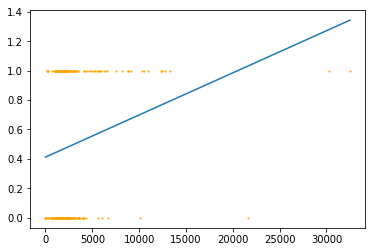

In [103]:
dataAllBodyLength = dataAll.copy()
for index, row in dataAllBodyLength.iterrows():
    textLength = len(row['text'])
    dataAllBodyLength.at[index, 'text_length'] = textLength


import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
linearRegressionBodyLength = LinearRegression(fit_intercept=True)

A = np.array(list(dataAllBodyLength.text_length))
B = np.array(list(dataAllBodyLength.veracity))

linearRegressionBodyLength.fit(A[:, np.newaxis], B)

xfit = np.linspace(-1, max(dataAllBodyLength.text_length), 1000)
yfit = linearRegressionBodyLength.predict(xfit[:, np.newaxis])

plt.scatter(A, B, s=1, c="orange")
plt.plot(xfit, yfit);

print("Model slope:    ", linearRegressionBodyLength.coef_[0])
print("Model intercept:", linearRegressionBodyLength.intercept_)
print("R2 score:", linearRegressionBodyLength.score(A[:, np.newaxis], B))

In [104]:
for index, row in dataTrain.iterrows():
    textLength = len(row['text'])
    dataTrain.at[index, 'text_length'] = textLength

for index, row in dataTest.iterrows():
    textLength = len(row['text'])
    dataTest.at[index, 'text_length'] = textLength

from sklearn import linear_model
# from sklearn import linear_model

logClassifierBodyLength = linear_model.LogisticRegression(solver='liblinear', C=17/1000, random_state=111)
logClassifierBodyLength.fit(dataTrain['text_length'].values.reshape(-1, 1), dataTrain['veracity'].values)

predicted = logClassifierBodyLength.predict(dataTest['text_length'].values.reshape(-1, 1))

from sklearn import metrics
print(metrics.accuracy_score(dataTest['veracity'].values.reshape(-1, 1), predicted))

0.7105263157894737


In [105]:
def DATAMINERS_getBodyLengthScore(length): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(length).reshape(-1, 1)
    predicted = logClassifierBodyLength.predict(x)
    predicedProb = logClassifierBodyLength.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProb)

print(DATAMINERS_getBodyLengthScore(12000))

0.20395870093748913


# Feature 10 : Word Frequency

In [106]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics

class WordFrequency():

    def __init__(self):        

        columnNames = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
        dataTrain = pd.read_csv('input_data/dataset/train.tsv', sep='\t', header=None, names = columnNames)
        dataValidate = pd.read_csv('input_data/dataset/valid.tsv', sep='\t', header=None, names = columnNames)
        dataTest = pd.read_csv('input_data/dataset/test.tsv', sep='\t', header=None, names = columnNames)
        
        #dropping columns
        columnsToRemove = ['id','subject', 'speaker', 'context','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataValidate = dataValidate.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)

        def convertMulticlassToBinaryclass(r):
            v = r['label']
            if (v == 'true'):
                return 'true'
            if (v == 'mostly-true'):
                return 'true'
            if (v == 'half-true'):
                return 'true'
            if (v == 'barely-true'):
                return 'false'
            if (v == 'false'):
                return 'false'
            if (v == 'pants-fire'):
                return 'false'
        dataTrain['label'] = dataTrain.apply(convertMulticlassToBinaryclass, axis=1)
        dataValidate['label'] = dataValidate.apply(convertMulticlassToBinaryclass, axis=1)
        dataTest['label'] = dataTest.apply(convertMulticlassToBinaryclass, axis=1)
        

    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
        train_tfidf = tfidfV.fit_transform(dataTrain['statement'].values)
        test_tfidf = tfidfV.fit_transform(dataTest['statement'].values)

#         print('TF-IDF VECTORIZER')

        ## Removing plurals for the tokens using PorterStemmer
        stemmer = PorterStemmer()
        tfidfVPlurals= tfidfV.get_feature_names()
        tfidfVSingles= [stemmer.stem(plural) for plural in tfidfVPlurals]

        # Applying Set to remove duplicates
        tfidfVTokens = list(set(tfidfVSingles))
#         print('TFIDFV Tokens')
#         print(tfidfVTokens)

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['statement'],dataTrain['label'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['statement'])
        score = metrics.accuracy_score(dataTest['label'], predicted_LogR)
        print("Word Frequency Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
# wf = WordFrequency()
# wf.predict("Says the Annies List political group supports third-trimester abortions on demand.")

In [107]:
# from ipynb.fs.full.m_wordfrequency import WordFrequency
wordFrequency = WordFrequency()

Word Frequency Model Trained - accuracy:   0.599053


In [108]:
def DATAMINERS_getWordFrequencyScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = wordFrequency.predict(text)
    return (1 - float(probValue))

print(DATAMINERS_getWordFrequencyScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.5104703891221563


# FINAL COMBINED MODEL

In [109]:
# import warnings
# warnings.filterwarnings('ignore')

def isFakeNews(text, headline="", numAuthors = 0, source = "", party =""):
    accur = [0.84, 0.56, 0.95, 0.35,  0.1 ,0.54, 0.98, 0.71, 0.6, 1] # using the (normalized) accuracy as weigths
    w = [float(i)/sum(accur) for i in accur]
    sumW = 0
    prob = []
    prob.append(w[0] * DATAMINERS_getAuthorScore(numAuthors))
    sumW += w[0]
    if ( (headline != "") & (party != "")):
        prob.append(w[1] * DATAMINERS_getPartyAffiliationScore(headline, party))
        sumW += w[1]
    if (headline != ""):
        prob.append(w[2] * DATAMINERS_getClickbaitScore(headline))
        sumW += w[2]
    if (headline != ""):
        prob.append(w[3] * DATAMINERS_getSentimentAnalysisScore(headline))
        sumW += w[3]
    if (headline != ""):
        prob.append(w[4] * DATAMINERS_getLDATopicModellingScore(headline))
        sumW += w[4]
    if (headline != ""):
        prob.append(w[5] * DATAMINERS_getSensationalismScore(headline))
        sumW += w[5]
    if (headline != ""):
        prob.append(w[6] * DATAMINERS_getSpamScore(headline))
        sumW += w[6]
    prob.append(w[7] * DATAMINERS_getBodyLengthScore(len(text)))
    sumW += w[7]
    prob.append(w[8] * DATAMINERS_getWordFrequencyScore(text))
    sumW += w[8]
    if (party != ""):
        prob.append(w[9] * DATAMINERS_getSourceReputationScore(source))
        sumW += w[9]
    
    probTotal = sum(prob[0:len(prob)]) / sumW
    return probTotal
    
result = isFakeNews("Yesterday, the Brazilian soccer team won the world cup by defeating Argentina", "World Cup ends", 1, "cnn.com", "republican")

if result > 0.5:
    print("is FAKE NEWS!!!")
else:
    print("it is NOT fake news!!!")
            

it is NOT fake news!!!


## Performance analysis 

In [110]:
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0
for index, row in dataTest.iterrows():
    text = row['text']
    headline= row['title']
    numAuthors = len(row['authors'])
    source = row['source']
    party = ""
    if 'party' in dataTest.columns:
        party = row['party']
    pred = isFakeNews(text, headline, numAuthors, source, party)
    if ((row['veracity'] == 1) &  (pred < 0.5) ):
        truePos += 1
    elif ((row['veracity'] == 0) & (pred >= 0.5) ):
        trueNeg += 1
    elif ((row['veracity'] == 1) &  (pred >= 0.5) ):
        falsePos += 1            
    elif ((row['veracity'] == 0) &  (pred < 0.5) ):
        falseNeg += 1
        
print("truePos=", truePos)
print("trueNeg=", trueNeg)
print("falsePos=", falsePos)
print("falseNeg=", falseNeg)
print("accuracy=", (truePos/(truePos+falseNeg)))

truePos= 19
trueNeg= 3
falsePos= 0
falseNeg= 16
accuracy= 0.5428571428571428


If we add some error margin, let's say 10p.p to make our model only trust the results beyong that margin, we have:
    

In [111]:
errorMargin = 0.10
ignored = 0
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0
for index, row in dataTest.iterrows():
    text = row['text']
    headline= row['title']
    numAuthors = len(row['authors'])
    source = row['source']
    party = ""
    if 'party' in dataTest.columns:
        party = row['party']
    pred = isFakeNews(text, headline, numAuthors, source, party)

    if (abs(0.5 - pred) < errorMargin):
        ignored += 1
    elif ((row['veracity'] == 1) &  (pred < 0.5) ):
        truePos += 1
    elif ((row['veracity'] == 0) & (pred >= 0.5) ):
        trueNeg += 1
    elif ((row['veracity'] == 1) &  (pred >= 0.5) ):
        falsePos += 1            
    elif ((row['veracity'] == 0) &  (pred < 0.5) ):
        falseNeg += 1

        
print("truePos=", truePos)
print("trueNeg=", trueNeg)
print("falsePos=", falsePos)
print("falseNeg=", falseNeg)
print("ignored=", ignored)
print("accuracy=", (truePos/(truePos+falseNeg)))

truePos= 17
trueNeg= 0
falsePos= 0
falseNeg= 14
ignored= 7
accuracy= 0.5483870967741935


In [112]:
train_clean_corpus = []

for i in train_news['clean']:
    train_clean_corpus.append(i)

In [123]:
bigrams = nltk.bigrams(train_clean_corpus[0].split(' '))

In [124]:
from collections import Counter

counter = Counter(bigrams)
print(counter.most_common(10))

[(('decline', 'coal'), 1), (('coal', 'start'), 1), (('start', 'start'), 1), (('start', 'natur'), 1), (('natur', 'gas'), 1), (('gas', 'took'), 1), (('took', 'start'), 1), (('start', 'begin'), 1), (('begin', 'presid'), 1), (('presid', 'george'), 1)]


In [122]:
train_clean_corpus[0].split(' ')

['decline',
 'coal',
 'start',
 'start',
 'natur',
 'gas',
 'took',
 'start',
 'begin',
 'presid',
 'george',
 'w',
 'bush',
 'administr']

In [133]:
train_news['clean'][1]

'decline coal start start natur gas took start begin presid george w bush administr'

In [138]:
train_news

,headline_text,clean,sensational_score
1.0,When did the decline of coal start? It started...,decline coal start start natur gas took start ...,0.061786
2.0,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agre john mccain vote give geo...,0.059743
3.0,Health care reform legislation is likely to ma...,health care reform legis like mandat free sex ...,0.052559
4.0,The economic turnaround started at the end of ...,econom turnaround start end term,0.066800
5.0,The Chicago Bears have had more starting quart...,chicago bear start quarterback last year total...,0.048691
6.0,Jim Dunnam has not lived in the district he re...,jim dunam live district repres year,0.041075
7.0,I'm the only person on this stage who has work...,person stage work activ last year pass along r...,0.052132
8.0,"However, it took $19.5 million in Oregon Lotte...",howe took million oregon lottery fund port new...,0.021112
9.0,Says GOP primary opponents Glenn Grothman and ...,say gop primary ippon glenn gaothan joe leibha...,0.041209
10.0,"For the first time in history, the share of th...",first time histori share nation popular vote m...,0.068641


## Feature: Corpus Structure

In [644]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

In [654]:
class CorpusStructure():
    
    def __init__(self):
        
        self.logisticRegression_pipeline = ''
        self.rf_pipeline = ''
        
        self.logisticRegression_enrich_pipeline = ''
        self.rf_enrich_pipeline = ''
    
    # binarize output label
    def binarizeOutputLabel(self, r):
        v = r['label']

        # consider 'true', 'mostly-true', 'half-true' as 1, others as 0
        if (v == 'true'):
            return 1
        if (v == 'mostly-true'):
            return 1
        if (v == 'half-true'):
            return 1
        if (v == 'barely-true'):
            return 0
        if (v == 'false'):
            return 0
        if (v == 'pants-fire'):
            return 0
    
    def logReg_pipline(self, ngram_rg=(1,1)):
    
        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)
        count_vectorizer = CountVectorizer(ngram_range=ngram_rg)
        
        X = count_vectorizer.fit_transform(train_news['clean'])
        # Testing the ngram generation:
        print("Get first 20 feature names:\n")
        print(count_vectorizer.get_feature_names()[: 20])
        print("\nPrint count vectorizer\n")
        print(X.toarray())
        
        X_train = tfidf_vectorizer.fit_transform(train_news['clean'].values)
        X_test = vectorizer.transform(test_news['clean'].values)
        
        train_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)
        test_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)

        y_train = train_news['binaryLabel']
        y_test = test_news['binaryLabel']
        
        self.logisticRegression_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', LogisticRegression(penalty='l2', C=98.684210526315795))
            ])

        # print(X_train.shape)
        # print(y_train.shape)

        self.logisticRegression_pipeline.fit(train_news['clean'].values, y_train)
        predicts = self.logisticRegression_pipeline.predict(test_news['clean'].values)
        score = metrics.accuracy_score(y_test, predicts)
        print("\n\nWord Frequency Model Trained - accuracy:   %0.6f" % score)
        print("\n")
        print(classification_report(y_test, predicts))
        
        param_grid = [{'C': np.linspace(90,100,20)}]

        grid_cv = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=10, verbose=1)
        grid_cv.fit(X_train_text, y_train_text)
        
        print("Best Params:\n")
        print(grid_cv.best_params_)
        print("Best Score:\n")        
        print(grid_cv.best_score_)
        
    def logReg_predict(self, text):
        predicted = self.logisticRegression_pipeline.predict([text])
        predicedProb = self.logisticRegression_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    def rf_pipline(self, ngram_rg=(1,1)):
                
        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)
        count_vectorizer = CountVectorizer(ngram_range=ngram_rg)
        
        X = count_vectorizer.fit_transform(train_news['clean'])
        # Testing the ngram generation:
        # print("Get first 20 feature names:\n")
        # print(count_vectorizer.get_feature_names()[: 20])
        # print("\nPrint count vectorizer\n")
        # print(X.toarray())
        
        X_train = tfidf_vectorizer.fit_transform(train_news['clean'].values)
        X_test = vectorizer.transform(test_news['clean'].values)
        
        train_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)
        test_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)

        y_train = train_news['binaryLabel']
        y_test = test_news['binaryLabel']
        
        self.logisticRegression_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', RandomForestClassifier(n_estimators = 300))
            ])

        # print(X_train.shape)
        # print(y_train.shape)

        self.logisticRegression_pipeline.fit(train_news['clean'].values, y_train)
        predicts = self.logisticRegression_pipeline.predict(test_news['clean'].values)
        score = metrics.accuracy_score(y_test, predicts)
        # Model Accuracy, how often is the classifier correct?
        print("Accuracy:",metrics.accuracy_score(y_test, predicts))

    def rf_predict(self, text):
        predicted = self.rf_pipline.predict([text])
        predicedProb = self.rf_pipline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    def data_enrichment(self):
        
        # Data enrichment
        # https://www.kaggle.com/snapcrack/all-the-news --- articles1
        df_articles = pd.read_csv("input_data/news/articles1.csv")
        df_articles.head(3)
        
        publications = np.unique(df_articles["publication"].values)
        print("publications:\n")
        print(publications)
        
        # We want to select several reputable publications for our dataset as well as several other 'less-reputable' publications in order to have a more balanced representation of news published by a real news publication company. Those we included are listed below.
        # We used a media bias/fact check website (source: https://mediabiasfactcheck.com/) to assess each news publication company. The results are below (each company is rated on their factual reporting).

        # Factual reporting:

        # Very High: reuters, npr
        # High: new york times, atlantic, guardian, washington post, vox
        # Mixed: fox news, cnn, national review
        df_articles = df_articles.loc[df_articles['publication'].isin(['New York Times', 'CNN','Atlantic','Fox News','Guardian','National Review','NPR','Reuters', 'Vox','Washington Post'])]
        # df_articles.head(3)
        # save to local csv file
        df_articles.to_csv('input_data/news/real_news.csv', encoding='utf-8')
        
        # https://www.kaggle.com/mrisdal/fake-news
        fake_news = pd.read_csv("input_data/news/fake.csv")
        # from local saved
        real_news = pd.read_csv("input_data/news/real_news.csv")
        
        real_news2 = real_news[['title', 'content', 'publication']]
        real_news2.dropna()
        real_news2['binaryLabel'] = 1
        real_news2.head(3)
    
        fake_news2 = fake_news[['title', 'text','site_url']]
        fake_news2.dropna()
        fake_news2['binaryLabel'] = 0
        fake_news2.head(5)
        
        # data cleaning
        fake_news2['clean'] = fake_news2['text'].apply(cleaning)
        real_news2['clean'] = real_news2['content'].apply(cleaning)
        print("After cleaning\n")
        fake_news2.head(3)
        real_news2.head(3)    
        
        # concatenate real and fake news data together
        data_news = [real_news2, fake_news2]
        df_news = pd.concat(data_news)[['clean', 'binaryLabel']]
        # train, test split
        df_train, df_test = train_test_split(df_news, test_size=0.2, random_state=0)
        
        # Enrich with original data frame
        df_news_enriched = [df_train, train_news]
        news_dataset = pd.concat(df_news_enriched)[['clean', 'binaryLabel']]
        #news_dataset.head(3)
        
        X_train_enrich = vectorizer.fit_transform(news_dataset['clean'].values)
        y_train_enrich = news_dataset['binaryLabel']
        
        X_test_enrich = [test_news, df_test]
        df_test_enrich = pd.concat(X_test_enrich)[['clean', 'binaryLabel']]
        X_test_enrich_clean = vectorizer.transform(df_test_enrich['clean'])
        X_test_enrich_clean.shape
        
        y_test_enrich = [y_test_text, df_test['binaryLabel']]
        df_y_test_enrich = pd.concat(y_test_enrich)
        df_y_test_enrich
        
        return news_dataset, df_test_enrich, df_y_test_enrich;
    
    def logReg_enrich_pipline(self, ngram_rg=(1,1)):
        
        news_dataset, df_test_enrich, df_y_test_enrich = self.data_enrichment()

        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)

        self.logisticRegression_enrich_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', LogisticRegression(penalty='l2', C=98.684210526315795))
            ])

        self.logisticRegression_enrich_pipeline.fit(news_dataset['clean'].values, news_dataset['binaryLabel'])
        predicts = self.logisticRegression_enrich_pipeline.predict(df_test_enrich['clean'].values)
        score = metrics.accuracy_score(df_y_test_enrich, predicts)
        # Model Accuracy, how often is the classifier correct?
        print("Accuracy:",metrics.accuracy_score(df_y_test_enrich, predicts))
        
        
    def rf_enrich_pipline(self, ngram_rg=(1,1)):
        
        news_dataset, df_test_enrich, df_y_test_enrich = self.data_enrichment()

        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)

        self.rf_enrich_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', RandomForestClassifier(n_estimators = 300))
            ])

        self.rf_enrich_pipeline.fit(news_dataset['clean'].values, news_dataset['binaryLabel'])
        predicts = self.rf_enrich_pipeline.predict(df_test_enrich['clean'].values)
        score = metrics.accuracy_score(df_y_test_enrich, predicts)
        # Model Accuracy, how often is the classifier correct?
        print("Accuracy:",metrics.accuracy_score(df_y_test_enrich, predicts))

In [655]:
corpusStructure = CorpusStructure()

In [658]:
corpusStructure.logReg_pipline(ngram_rg=(1,1))

Get first 20 feature names:

['aa', 'aaa', 'aaron', 'aarp', 'aba', 'abandon', 'abba', 'abbott', 'abc', 'abdul', 'abel', 'abid', 'abig', 'abil', 'abject', 'abl', 'aboard', 'abolish', 'abort', 'abortioneven']

Print count vectorizer

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Word Frequency Model Trained - accuracy:   0.516180


              precision    recall  f1-score   support

           0       0.44      0.40      0.42       551
           1       0.57      0.60      0.58       716

   micro avg       0.52      0.52      0.52      1267
   macro avg       0.50      0.50      0.50      1267
weighted avg       0.51      0.52      0.51      1267

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Params:

{'C': 90.0}
Best Score:

0.56591796875


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.7s finished


In [659]:
corpusStructure.rf_pipline(ngram_rg=(1,1))

Accuracy: 0.5122336227308603


In [628]:
corpusStructure.logReg_pipline(ngram_rg=(2,2))

Get first 20 feature names:

['aa aaa', 'aaa bond', 'aaa credit', 'aaron bean', 'aarp consist', 'aarp largest', 'aarp say', 'aarp vendors', 'aba criterion', 'abandon dollar', 'abandon home', 'abandon republican', 'abba leader', 'abba one', 'abbott becom', 'abbott benefit', 'abbott campaign', 'abbott charg', 'abbott convert', 'abbott defend']

Print count vectorizer

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Word Frequency Model Trained - accuracy:   0.508287


              precision    recall  f1-score   support

           0       0.44      0.48      0.46       551
           1       0.57      0.53      0.55       716

   micro avg       0.51      0.51      0.51      1267
   macro avg       0.50      0.50      0.50      1267
weighted avg       0.51      0.51      0.51      1267

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Params:

{'C': 90.0}
Best Score:

0.56591796875


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.9s finished


In [629]:
corpusStructure.rf_pipline(ngram_rg=(2,2))

Accuracy: 0.4988161010260458


In [660]:
corpusStructure.logReg_pipline(ngram_rg=(3,3))

Get first 20 feature names:

['aa aaa bond', 'aaa bond rate', 'aaa credit rate', 'aaron bean vote', 'aarp consist communis', 'aarp largest rebel', 'aarp say health', 'aarp vendors health', 'aba criterion judicial', 'abandon dollar multi', 'abandon home serv', 'abandon republican stood', 'abba leader fatal', 'abba one member', 'abbott becom attorney', 'abbott benefit payday', 'abbott campaign sexual', 'abbott charg overs', 'abbott convert million', 'abbott defend billion']

Print count vectorizer

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Word Frequency Model Trained - accuracy:   0.532755


              precision    recall  f1-score   support

           0       0.40      0.15      0.21       551
           1       0.56      0.83      0.67       716

   micro avg       0.53      0.53      0.53      1267
   macro avg       0.48      0.49      0.44      1267
weighted avg       0.49      0.53      0.47      1267

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Params:

{'C': 90.0}
Best Score:

0.56591796875


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.7s finished


In [661]:
corpusStructure.rf_pipline(ngram_rg=(3,3))

Accuracy: 0.5390686661404893


In [656]:
corpusStructure.logReg_enrich_pipline()

publications:

['Atlantic' 'Breitbart' 'Business Insider' 'CNN' 'New York Times']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

After cleaning



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Accuracy: 0.8768041237113402


In [1]:
corpusStructure.rf_enrich_pipline()

NameError: name 'corpusStructure' is not defined

# Stance started here

In [3]:
from ast import literal_eval

pdsbank = pd.read_csv('input_data/stance/cred_event_TurkRatings.data', error_bad_lines=False, delimiter = '\t')
pdsbank.head()

,topic_key,topic_terms,Cred_Ratings,Reasons
0,everything_royals_rain-20141015_161647-2014101...,"[u'everything', u'royals', u'rain']","['2', '1', '0', '2', '1', '1', '2', '2', '2', ...","['Game suspended due to rain', 'It is true tha..."
1,host_patrick_neil-20141015_161647-20141015_172214,"[u'host', u'patrick', u'neil']","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",['Neil Patrick Harris will host the 2015 Oscar...
2,royals_game_series-20141015_203526-20141015_21...,"[u'royals', u'game', u'series']","['2', '1', '2', '2', '2', '0', '2', '2', '1', ...",['The Royals did win last night and are indeed...
3,giants_game_win-20141015_230140-20141016_000502,"[u'giants', u'game', u'win']","['2', '2', '2', '2', '2', '2', '2', '2', '0', ...","['They did win the game.', 'Major news sources..."
4,october_ebola_house-20141015_230140-20141016_0...,"[u'october', u'ebola', u'house']","['1', '2', '2', '1', '2', '1', '1', '2', '2', ...","['Accurate news story, some opinion.', 'USA To..."


In [4]:
pdsbank.loc[:,'Cred_Ratings'] = pdsbank.loc[:,'Cred_Ratings'].apply(lambda x: literal_eval(x))
pdsbank = pdsbank.drop(['Reasons','topic_key','topic_terms'], axis = 1)
len(pdsbank.loc[0,'Cred_Ratings'])

30

In [5]:
barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts = [],[],[],[],[]
for i, rows in pdsbank.iterrows():
    countmos = 0
    counthalf =0
    countbare = 0
    countfal = 0
    countpant = 0
    for row in rows['Cred_Ratings']:
        if int(row) == 2:
            countmos += 1
        elif int(row) == 1:
            counthalf += 1
        elif int(row) == 0:
            countbare += 1
        elif int(row) == -1:
            countfal += 1
        elif int(row) == -2:
            countpant += 1
        else :
            print('something went wrong')
    mostlytrueocunts.append(countmos)
    halftruecounts.append(counthalf)
    barelytruecounts.append(countbare)
    falsecounts.append(countfal)
    pantsonfirecounts.append(countpant)

print(len(pantsonfirecounts),len(falsecounts))
#pantsonfirecounts

1378 1378


In [6]:
d = {'barelytruecounts':barelytruecounts,
     'falsecounts':falsecounts,
     'halftruecounts':halftruecounts,
     'mostlytrueocunts':mostlytrueocunts,
     'pantsonfirecounts':pantsonfirecounts}
data_enrich = pd.DataFrame(data=d)
data_enrich.head()

,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts
0,4,1,9,16,0
1,0,0,0,30,0
2,1,0,3,26,0
3,1,0,1,28,0
4,3,2,12,12,1


In [7]:
import math 

def data_label(row):
    su =[]
    su.append(row['barelytruecounts'] * 1)
    su.append(row['falsecounts'] * -1)
    su.append(row['halftruecounts'] * 0)
    su.append(row['mostlytrueocunts']* 2)
    su.append(row['pantsonfirecounts']* -2)
    
    means =sum(su)/5
    if means <= 0:
        means = 1
    # culculate standard deviation
    std = np.std(su)
    # culculate conflict based on mean, set threshold 
    if math.log(means,std) < 75/100:
        return 0
    else:
        return 1
data_enrich['label'] = data_enrich.apply (lambda row: data_label(row), axis=1)
data_enrich.head()

,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,label
0,4,1,9,16,0,1
1,0,0,0,30,0,1
2,1,0,3,26,0,1
3,1,0,1,28,0,1
4,3,2,12,12,1,0


In [8]:
# Stance based detection begins here
#load data into pandas
train_news_st = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news_st = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news_st = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)
train_news_st.head()
#remove rows have no viewpoint
train_news_st = train_news_st[(train_news_st.barelytruecounts > 0) |
                              (train_news_st.falsecounts > 0) |
                              (train_news_st.halftruecounts > 0) |
                              (train_news_st.mostlytrueocunts > 0) |
                              (train_news_st.pantsonfirecounts > 0)]
test_news_st = test_news_st[(test_news_st.barelytruecounts > 0) |
                              (test_news_st.falsecounts > 0) |
                              (test_news_st.halftruecounts > 0) |
                              (test_news_st.mostlytrueocunts > 0) |
                              (test_news_st.pantsonfirecounts > 0)]
valid_news_st = valid_news_st[(valid_news_st.barelytruecounts > 0) |
                              (valid_news_st.falsecounts > 0) |
                              (valid_news_st.halftruecounts > 0) |
                              (valid_news_st.mostlytrueocunts > 0) |
                              (valid_news_st.pantsonfirecounts > 0)]
train_news_st.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [9]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
print(keras.__version__)

2.2.4-tf


In [10]:
#convert Multiclass To Binary class
def convertMulticlassToBinaryclass(r):
    v = r['label'].lower()
    if (v == 'true'):
        return 1
    if (v == 'mostly-true'):
        return 1
    if (v == 'half-true'):
        return 1
    if (v == 'barely-true'):
        return 0
    if (v == 'false'):
        return 0
    if (v == 'pants-fire'):
        return 0
    else:
        print('find some wrong',v)
train_news_st['label'] = train_news_st.apply(convertMulticlassToBinaryclass, axis=1)
test_news_st['label'] = test_news_st.apply(convertMulticlassToBinaryclass, axis=1)
valid_news_st['label'] = valid_news_st.apply(convertMulticlassToBinaryclass, axis=1)
#feature selecting
colnames_st_label = ['label']
colnames_st_train = ['barelytruecounts','falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts']
train_news_st_l = train_news_st[colnames_st_label].values
valid_news_st_l = valid_news_st[colnames_st_label].values
test_news_st_l = test_news_st[colnames_st_label].values

# normalize viewpoints
mms = MinMaxScaler()
train_news_st_t = mms.fit_transform(train_news_st[colnames_st_train])
valid_news_st_t = mms.fit_transform(valid_news_st[colnames_st_train])
test_news_st_t = mms.fit_transform(test_news_st[colnames_st_train])

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
d:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
valid_news_st_l
train_news_st_t
train_news_st_t.shape
train_news_st_t[3]
train_news_st_t

array([[0.        , 0.00877193, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00625   , 0.00613497, 0.        ],
       [1.        , 0.62280702, 1.        , 1.        , 0.08571429],
       ...,
       [0.05714286, 0.09649123, 0.03125   , 0.01840491, 0.02857143],
       [0.04285714, 0.00877193, 0.01875   , 0.        , 0.        ],
       [0.        , 0.00877193, 0.00625   , 0.        , 0.01904762]])

In [12]:
from tensorflow.keras.layers import LeakyReLU

model = keras.Sequential()
model.add(keras.layers.Dense(8, input_dim=5))
model.add(keras.layers.Dense(4,activation="tanh"))
#model.add(LeakyReLU(alpha=0.3))
model.add(keras.layers.Dense(1, activation="sigmoid"))
        
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(train_news_st_t,
                    train_news_st_l,
                    epochs=50,
                    batch_size=8,
                    validation_data=(valid_news_st_t, valid_news_st_l),
                    verbose=1)

Train on 9901 samples, validate on 1253 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
9901/9901 [==============================] - 5s 483us/sample - loss: 0.6719 - acc: 0.5762 - val_loss: 0.6722 - val_acc: 0.5507
Epoch 2/50
9901/9901 [==============================] - 3s 276us/sample - loss: 0.6654 - acc: 0.5863 - val_loss: 0.6663 - val_acc: 0.5714
Epoch 3/50
9901/9901 [==============================] - 3s 275us/sample - loss: 0.6644 - acc: 0.5889 - val_loss: 0.6635 - val_acc: 0.5698
Epoch 4/50
9901/9901 [==============================] - 3s 261us/sample - loss: 0.6616 - acc: 0.5922 - val_loss: 0.6605 - val_acc: 0.5674
Epoch 5/50
9901/9901 [==============================] - 2s 252us/sample - loss: 0.6587 - acc: 0.5961 - val_loss: 0.6631 - val_acc: 0.5626
Epoch 6/50
9901/9901 [==============================] - 3s 256us/sample - loss: 0.6559 - acc: 0.6006 - val_loss: 0.6549 - val_acc: 0.5682
Epoch 7/50
9901/9901 [==============================] - 3s 259us/sample - lo

In [15]:
results = model.evaluate(test_news_st_t, test_news_st_l)

print(results)

1232/1232 [==============================] - 0s 33us/sample - loss: 0.5228 - acc: 0.7321
[0.5228305675766685, 0.73214287]


In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

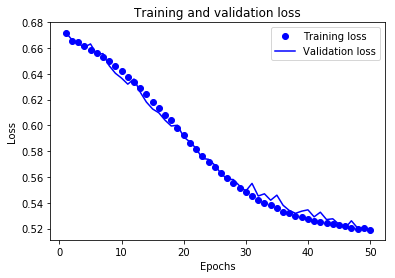

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

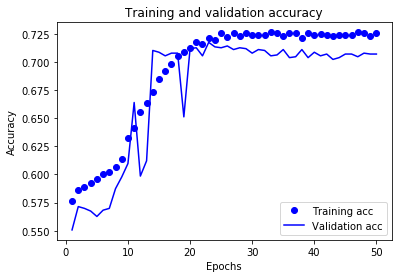

In [18]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
model.predict_classes(valid_news_st_t, verbose=1).sum()

1253/1253 [==============================] - 0s 24us/sample


814

# Political Bias (Samuel Yang part):

In [503]:
p_news = pd.read_csv('input_data/political_social_media.csv',encoding='latin1')
p_news.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


In [504]:
p_news.dropna(axis = 'columns', inplace = True)
p_news.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,message:confidence,bioid,embed,id,label,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,1.0,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,1.0,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,1.0,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,1.0,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,1.0,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...


In [505]:
cols_to_drop = ['_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at',
                'audience:confidence', 'bias:confidence', 'message:confidence', 'bioid', 'embed','id']
p_news.drop(cols_to_drop,inplace = True,axis = 1)
p_news.head()

,_unit_id,audience,bias,message,label,source,text
0,766192484,national,partisan,policy,From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,national,partisan,attack,From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,national,neutral,support,From: Kurt Schrader (Representative from Oregon),twitter,Please join me today in remembering our fallen...
3,766192487,national,neutral,policy,From: Michael Crapo (Senator from Idaho),twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,national,partisan,policy,From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...


In [506]:
for i in ['audience', 'bias', 'message','source']:
    print()
    print(p_news[i].value_counts())



national        3971
constituency    1029
Name: audience, dtype: int64

neutral     3689
partisan    1311
Name: bias, dtype: int64

policy          1411
personal        1170
support          921
information      647
media            277
attack           172
constituency     152
mobilization     129
other            121
Name: message, dtype: int64

facebook    2500
twitter     2500
Name: source, dtype: int64


In [507]:
p_news.replace({'bias': {'neutral': 0, 'partisan': 1}}, inplace = True)
p_news.replace({'audience': {'national': 0, 'constituency': 1}}, inplace = True)
p_news.replace({'source': {'facebook': 0, 'twitter': 1}}, inplace = True)
p_news.replace({'message' : {'policy': 0, 'personal': 1, 'support': 2, 'information': 3,
                            'media': 4, 'attack': 5, 'constituency':6, 'mobilization': 7, 'other': 8}}, inplace = True)

In [508]:
p_news.head()
p_news_data = pd.DataFrame({"audience": p_news['audience'].values, "source":p_news["source"], "message": p_news["message"].values,
                                "bias": p_news['bias'].values})

In [509]:
p_news_data.head()

,audience,source,message,bias
0,0,1,0,1
1,0,1,5,1
2,0,1,2,0
3,0,1,0,0
4,0,1,0,1


In [510]:
p_news_y = p_news_data['bias']
p_news_X = p_news_data.drop(['bias'],axis = 1)

p_X_train, p_X_test, p_y_train, p_y_test = train_test_split( p_news_X, p_news_y, test_size=0.33, random_state=42)

### Linear Regression Model:

In [511]:
p_lnrclf = linear_model.LinearRegression() 
p_lnrclf.fit(p_X_train, p_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [512]:
from sklearn.model_selection import cross_val_score

print('Coefficients:', p_lnrclf.coef_) 
print('\nVariance score: {}\n'.format(p_lnrclf.score(p_X_test, p_y_test))) 
print('Cross-Val scores: {}'.format(cross_val_score(p_lnrclf, p_X_train, p_y_train, cv=4)))

Coefficients: [-0.12437576  0.07599449 -0.02283036]

Variance score: 0.022128006147813073

Cross-Val scores: [0.02431744 0.02804964 0.02568711 0.04840319]


### Logistic Regression Model:

In [513]:
p_lgclf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(p_X_train, p_y_train)

In [514]:
print('Coefficients:', p_lgclf.coef_) 
print('\nVariance score: {}\n'.format(p_lgclf.score(p_X_test, p_y_test))) 
print('Cross-Val scores: {}'.format(cross_val_score(p_lgclf, p_X_train, p_y_train, cv=4)))

Coefficients: [[-0.37294197  0.19809972 -0.06591262]]

Variance score: 0.7533333333333333

Cross-Val scores: [0.73031026 0.73031026 0.72998805 0.72998805]


### Random Forest Model:

In [515]:
from sklearn.ensemble import RandomForestClassifier
p_rfclf = RandomForestClassifier().fit(p_X_train, p_y_train)

In [516]:
print('\nVariance score: {}\n'.format(p_rfclf.score(p_X_test, p_y_test))) 
print('Cross-Val scores: {}'.format(cross_val_score(p_rfclf, p_X_train, p_y_train, cv=4)))


Variance score: 0.796969696969697

Cross-Val scores: [0.79355609 0.77804296 0.75029869 0.80645161]


### LDA:

In [517]:
p_lda = p_news.drop(['source', 'label', 'message', 'audience', 'bias'], axis = 1)
p_lda.rename(index=str, columns={"_unit_id": "index"}, inplace = True)

p_lda.replace("")

p_lda.head()

,index,text
0,766192484,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,Please join me today in remembering our fallen...
3,766192487,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,.@amazon delivery #drones show need to update ...


In [518]:
def process_text(text):
        result = text.replace('/', '').replace('\n', '')
        result = re.sub(r'[1-9]+', 'number', result)
        result = re.sub(r'(\w)(\1{2,})', r'\1', result)
        result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
        result = ''.join(t for t in result if t not in punctuation)
        result = re.sub(r' +', ' ', result).lower().strip()
        return result

In [519]:
print("Before Processed Text:\n", p_lda['text'].iloc[0])

p_lda['text'] = p_lda['text'].apply(process_text)
print("\nAfter Processed Text:\n", p_lda['text'].iloc[0])

Before Processed Text:
 RT @nowthisnews: Rep. Trey Radel (R- #FL) slams #Obamacare. #politics https://t.co/zvywMG8yIH

After Processed Text:
 rt nowthisnews rep trey radel r fl slams obamacare politics httpstcozvywmgnumberyih


In [520]:
p_lda.rename(index=str, columns={"text": "clean"}, inplace = True)
p_lda['index'] = p_lda.index
p_lda.head()

,index,clean
0,0,rt nowthisnews rep trey radel r fl slams obama...
1,1,video obamacare full of higher costs and broke...
2,2,please join me today in remembering our fallen...
3,3,rt senatorleahy numberst step toward senate de...
4,4,amazon delivery drones show need to update law...


In [521]:
p_lda_train, p_lda_test, p_lda_valid = p_lda[:3000], p_lda[3000:4000], p_lda[4000:]

p_lda_test['index'] = p_lda[:1000].index
#p_lda_test.set_index(['index'], inplace = True)
p_lda_valid['index'] = p_lda[:1000].index
#p_lda_valid.set_index(['index'], inplace = True)

In [522]:
p_lda_train.head()

,index,clean
0,0,rt nowthisnews rep trey radel r fl slams obama...
1,1,video obamacare full of higher costs and broke...
2,2,please join me today in remembering our fallen...
3,3,rt senatorleahy numberst step toward senate de...
4,4,amazon delivery drones show need to update law...


In [523]:
p_lda_test.head()

,index,clean
3000,0,just a reminder that though the federal system...
3001,1,nada podrìá reemplazar el daì±o y las vidas pe...
3002,2,today it looks like were going to vote again t...
3003,3,congress is a very serious solemn place cccesa...
3004,4,about to start our special order cirmeansjobs


In [524]:
p_lda_valid.head()

,index,clean
4000,0,open enrollment starts today if you have quest...
4001,1,today i voted against the pay china first act ...
4002,2,learn more about passport day below
4003,3,the presidents state of the union is tonight w...
4004,4,today is the start of black history month let ...


In [525]:
tokenized_docs_local = p_lda_train['clean'].map(get_word_tokens)

In [526]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(p_lda_train,
                                                                      'clean')

######## DICTIONARY Words and occurences ########
0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 third
9 trimmest
10 administr

 ######## BOW VECTOR FIRST ITEM ########
[(281, 1)]

 ######## PREVIEW BOW ########
Word 281 ("obamacare") appears 1 time.


In [527]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['watch', 'support', 'your', 'number', 'town', 'talk', 'thank', 'check', 'that', 'protect']
1::['great', 'that', 'time', 'obamacare', 'number', 'today', 'health', 'student', 'american', 'find']
2::['bill', 'today', 'week', 'congress', 'number', 'country', 'plan', 'that', 'news', 'border']
3::['number', 'that', 'today', 'obamacare', 'join', 'obama', 'right', 'school', 'president', 'your']
4::['work', 'today', 'they', 'that', 'number', 'great', 'would', 'congress', 'back', 'must']
5::['time', 'week', 'today', 'that', 'staff', 'state', 'meet', 'community', 'visit', 'year']
6::['your', 'care', 'american', 'today', 'access', 'best', 'read', 'health', 'that', 'give']
7::['number', 'that', 'last', 'health', 'help', 'your', 'america', 'today', 'first', 'would']
8::['today', 'help', 'president', 'great', 'good', 'obama', 'live', 'health', 'work', 'research']
9::['great', 'forward', 'number', 'make', 'today', 'read', 'your', 'state', 'take', 'that']


In [528]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 ######## TFIDF VECTOR FIRST ITEM ########
[(281, 1.0)]


In [529]:
lda_tfidf_model_headline  = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['great', 'check', 'talk', 'number', 'local', 'next', 'event', 'today', 'must', 'good']
1::['obama', 'stop', 'number', 'best', 'president', 'show', 'care', 'week', 'that', 'mcconnell']
2::['today', 'number', 'news', 'that', 'read', 'congressional', 'good', 'work', 'live', 'research']
3::['number', 'help', 'forward', 'safe', 'thank', 'john', 'first', 'they', 'town', 'state']
4::['support', 'great', 'student', 'today', 'thank', 'hope', 'make', 'friend', 'visit', 'number']
5::['obamacare', 'great', 'number', 'look', 'today', 'park', 'capitol', 'call', 'that', 'town']
6::['work', 'your', 'join', 'bill', 'obama', 'today', 'budget', 'speech', 'president', 'report']
7::['public', 'number', 'county', 'photo', 'program', 'recent', 'staff', 'today', 'follow', 'share']
8::['watch', 'great', 'that', 'american', 'there', 'number', 'live', 'meet', 'today', 'better']
9::['number', 'today', 'time', 'last', 'bill', 'congress', 'health', 'military', 'that', 'reform']


In [530]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

In [531]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
p_lda_train = update_lda_results_to_dataset(
    p_lda_train, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)
p_lda_train.head()

,index,clean,topic_number,lda_score,topic_top_words
0,0,rt nowthisnews rep trey radel r fl slams obama...,1,0.549944,great that time obamacare number today health ...
1,1,video obamacare full of higher costs and broke...,3,0.774959,number that today obamacare join obama right s...
2,2,please join me today in remembering our fallen...,3,0.409554,number that today obamacare join obama right s...
3,3,rt senatorleahy numberst step toward senate de...,2,0.849980,bill today week congress number country plan t...
4,4,amazon delivery drones show need to update law...,2,0.849968,bill today week congress number country plan t...


In [532]:
p_lda_test = update_lda_results_to_dataset(
    p_lda_test,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)
p_lda_test.head()

,index,clean,topic_number,lda_score,topic_top_words
3000,0,just a reminder that though the federal system...,6,0.524597,your care american today access best read heal...
3001,1,nada podrìá reemplazar el daì±o y las vidas pe...,0,0.100000,watch support your number town talk thank chec...
3002,2,today it looks like were going to vote again t...,7,0.291829,number that last health help your america toda...
3003,3,congress is a very serious solemn place cccesa...,2,0.774974,bill today week congress number country plan t...
3004,4,about to start our special order cirmeansjobs,2,0.774913,bill today week congress number country plan t...


In [533]:
p_lda_valid = update_lda_results_to_dataset(
    p_lda_valid,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)
p_lda_valid.head()

,index,clean,topic_number,lda_score,topic_top_words
4000,0,open enrollment starts today if you have quest...,7,0.924977,number that last health help your america toda...
4001,1,today i voted against the pay china first act ...,3,0.887468,number that today obamacare join obama right s...
4002,2,learn more about passport day below,0,0.100000,watch support your number town talk thank chec...
4003,3,the presidents state of the union is tonight w...,8,0.819941,today help president great good obama live hea...
4004,4,today is the start of black history month let ...,1,0.660264,great that time obamacare number today health ...


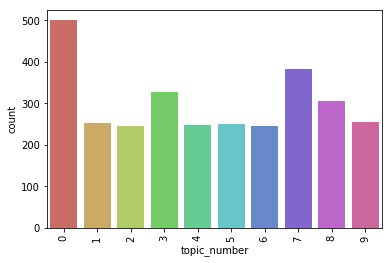

In [534]:
create_distribution(p_lda_train)

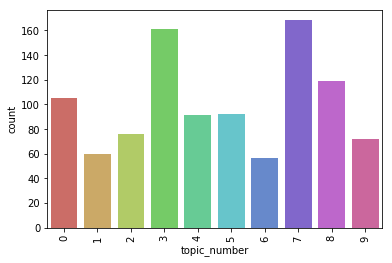

In [535]:
create_distribution(p_lda_test)

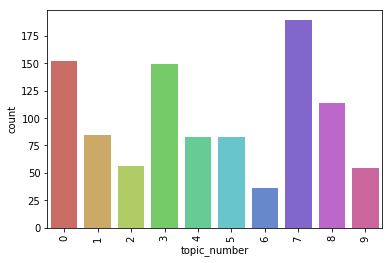

In [536]:
create_distribution(p_lda_valid)

In [537]:
p_lda_train.to_csv("input_data/p_lda_train.csv", sep=',')
p_lda_test.to_csv("input_data/p_lda_test.csv", sep=',')
p_lda_valid.to_csv("input_data/p_lda_valid.csv", sep=',')

In [538]:
dataTrain = pd.read_csv('input_data/p_lda_train.csv', sep=',')
dataTest = pd.read_csv('input_data/p_lda_test.csv', sep=',')

In [539]:
dataTrain.drop(dataTrain.columns[0], axis=1,inplace = True)
dataTest.drop(dataTest.columns[0], axis=1,inplace = True)
dataTest.dropna(inplace = True)
dataTest.head()

,index,clean,topic_number,lda_score,topic_top_words
0,0,just a reminder that though the federal system...,6,0.524597,your care american today access best read heal...
1,1,nada podrìá reemplazar el daì±o y las vidas pe...,0,0.100000,watch support your number town talk thank chec...
2,2,today it looks like were going to vote again t...,7,0.291829,number that last health help your america toda...
3,3,congress is a very serious solemn place cccesa...,2,0.774974,bill today week congress number country plan t...
4,4,about to start our special order cirmeansjobs,2,0.774913,bill today week congress number country plan t...


In [540]:
tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30,
                         use_idf=True, smooth_idf=True,
                         token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

p_lda_lnrclf = Pipeline([('LogRCV', tfidfV),('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))])
p_lda_lnrclf.fit(dataTrain['clean'],dataTrain['topic_number']) 
pred_y = p_lda_lnrclf.predict(dataTest['clean'])
score = metrics.accuracy_score(dataTest['topic_number'], pred_y)
print("LDA Score: %0.6f" % score)    
    
        

LDA Score: 0.266266


#### Given the news, by making analysis on the correlations between the sources, content, audience, and what kind of message they are categorized on, we can make prediction on how bias it will be. Either it is national or constitutional message, or either it is related to policy or personal, the level of bias can all be predicted accordingly.

#### With topic modeling and LDA model training, there's a fair chance that we can predict what a biased politican will say, based on all the given news. As we can see, ususally there are latent factors in biased information and can be discovered if we keep doing data mining. From the LDA modeling, words can be predicted.